In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import skew
import igraph
import os
pd.set_option('display.max_columns', 30)

In [2]:
ddir = "/home/scai/PhenPred/data/"
data_folder = "/home/scai/PhenPred/data/clines"

In [3]:
# Import samplesheets
cols = ["model_id", "BROAD_ID", "tissue", "cancer_type"]
col_rename = dict(
    ModelID="BROAD_ID",
    SangerModelID="model_id",
    SampleCollectionSite="tissue",
    OncotreeLineage="cancer_type",
)
ss_cmp = pd.read_csv(f"{data_folder}/model_list_20230505.csv")

ss_depmap = pd.read_csv(f"{data_folder}/depmap24Q4/Model.csv")
ss_depmap.rename(columns=col_rename, inplace=True)

# Map sample IDs to Sanger IDs
samplesheet = pd.concat(
    [
        ss_cmp[cols].dropna().assign(source="sanger"),
        ss_depmap[cols].dropna().assign(source="broad"),
    ]
)
samplesheet = samplesheet.groupby("model_id").first().reset_index()
samplesheet.replace(
    {
        "tissue": dict(
            large_intestine="Large Intestine",
            lung="Lung",
            ovary="Ovary",
            haematopoietic_and_lymphoid_tissue="Haematopoietic and Lymphoid",
            bone_marrow="Other tissue",
            upper_aerodigestive_tract="Other tissue",
            ascites="Other tissue",
            pleural_effusion="Other tissue",
        )
    },
    inplace=True,
)
tissue_map = samplesheet.set_index("model_id").to_dict()["tissue"]

# Growth
growth = pd.read_csv(f"{data_folder}/growth_rate_20220907.csv")
growth = (
    growth.sort_values(["model_id", "replicates"], ascending=False)
    .groupby("model_id")
    .first()
)
growth = growth.dropna(subset=["day4_day1_ratio"])

In [4]:
samplesheet.head()

model_id    BROAD_ID                       tissue          cancer_type  \
0  SIDM00001  ACH-000405  Haematopoietic and Lymphoid  Other Blood Cancers   
1  SIDM00002  ACH-002340    Peripheral Nervous System        Neuroblastoma   
2  SIDM00003  ACH-002159                         Skin             Melanoma   
3  SIDM00005  ACH-000044                       Breast     Breast Carcinoma   
4  SIDM00006  ACH-001552                         Skin  Other Solid Cancers   

   source  
0  sanger  
1  sanger  
2  sanger  
3  sanger  
4  sanger

In [5]:
samplesheet['tissue'].unique()

array(['Haematopoietic and Lymphoid', 'Peripheral Nervous System', 'Skin',
       'Breast', 'Ovary', 'Large Intestine', 'Esophagus', 'Lung',
       'Head and Neck', 'Central Nervous System', 'Kidney', 'Soft Tissue',
       'Bladder', 'Bone', 'Thyroid', 'Endometrium', 'Stomach', 'Pancreas',
       'Liver', 'Cervix', 'Eye', 'Prostate', 'Biliary Tract', 'Uterus',
       'Testis', 'Other tissue', 'Placenta', 'Small Intestine',
       'Adrenal Gland', 'Vulva', 'Unknown'], dtype=object)

In [6]:
PALETTE_TTYPE = {
    "Lung": "#007fff",
    "Prostate": "#665d1e",
    "Stomach": "#ffbf00",
    "Central Nervous System": "#fbceb1",
    "Skin": "#ff033e",
    "Bladder": "#ab274f",
    "Haematopoietic and Lymphoid": "#d5e6f7",
    "Kidney": "#7cb9e8",
    "Thyroid": "#efdecd",
    "Soft Tissue": "#8db600",
    "Head and Neck": "#e9d66b",
    "Ovary": "#b284be",
    "Bone": "#b2beb5",
    "Endometrium": "#10b36f",
    "Breast": "#6e7f80",
    "Pancreas": "#ff7e00",
    "Peripheral Nervous System": "#87a96b",
    "Cervix": "#c9ffe5",
    "Large Intestine": "#9f2b68",
    "Liver": "#00ffff",
    "Vulva": "#008000",
    "Esophagus": "#cd9575",
    "Biliary Tract": "#72a0c1",
    "Other tissue": "#a32638",
    "Small Intestine": "#9966cc",
    "Placenta": "#f19cbb",
    "Testis": "#e32636",
    "Adrenal Gland": "#3b7a57",
    "Uterus": "#7a3b5e",
    "Unknown": "#a32638",
    "Eye": "#ff1493",
}

In [7]:
timestamp = "20250225_145621"
# Datasets - synthetic
## Transcriptomics
gexp_df = pd.read_csv(
    f"/home/scai/PhenPred/reports/vae/files/{timestamp}_imputed_transcriptomics.csv.gz",
    index_col=0,
)

## CRISPR-Cas9
cas9_df = pd.read_csv(
    f"/home/scai/PhenPred/reports/vae/files/{timestamp}_imputed_crisprcas9.csv.gz",
    index_col=0,
)

In [8]:
growth.shape

(964, 6)

In [9]:
gexp_measured = pd.read_csv(
    f"{data_folder}/depmap24Q4/OmicsExpressionGenesExpectedCountProfileVoom.csv",
    index_col=0,
).T
gexp_measured = gexp_measured.rename(
    index=samplesheet.reset_index().groupby("BROAD_ID").first()["model_id"]
)
gexp_measured = gexp_measured[gexp_measured.index.isin(gexp_df.index)]

In [10]:
## CRISPR-Cas9
cas9_measured = pd.read_csv(
    f"{data_folder}/depmap24Q4/CRISPRGeneEffect.csv", index_col=0
)
cas9_measured.columns = cas9_measured.columns.str.split(" ").str[0]
# cas9_measured = scale(cas9_measured.T).T
cas9_measured = cas9_measured.rename(
    index=samplesheet.reset_index().groupby("BROAD_ID").first()["model_id"]
)
cas9_measured = cas9_measured[cas9_measured.index.isin(cas9_df.index)]

In [11]:
measured_gexp_only = list(set(gexp_measured.index) - set(cas9_measured.index))
measured_cas9_only = list(set(cas9_measured.index) - set(gexp_measured.index))
measured_both = list(set(gexp_measured.index) & set(cas9_measured.index))

In [12]:
measured_groups = {
    "both": measured_both,
    "gexp_only": measured_gexp_only,
    "cas9_only": measured_cas9_only,
    "none": [],  # Will be automatically assigned for remaining samples
}

In [13]:
gexp_df.shape

(1532, 15295)

In [14]:
def plot_cas9_vs_gexp_comparison(
    cas9_id: str,
    gexp_id: str,
    cas9_df: pd.DataFrame,
    gexp_df: pd.DataFrame,
    measured_groups: dict,
    tissue_map: dict,
):
    """
    Create a 2x2 multi-panel scatter plot comparing gene expression and Cas9 scores using Seaborn.

    Parameters:
    -----------
    cas9_id : str
        Column name for Cas9 scores
    gexp_id : str
        Column name for gene expression scores
    cas9_df : pd.DataFrame
        DataFrame containing Cas9 scores
    gexp_df : pd.DataFrame
        DataFrame containing gene expression scores
    measured_groups : dict
        Dictionary with keys 'both', 'gexp_only', 'cas9_only', 'none'
        containing indices for each group
    tissue_map : dict
        Dictionary mapping model_ids to tissue types
    PALETTE_TTYPE : dict
        Dictionary mapping tissue types to colors.

    Returns:
    --------
    fig : matplotlib.figure.Figure
        The generated figure
    """
    import numpy as np
    import pandas as pd
    from scipy import stats
    import matplotlib.pyplot as plt
    import matplotlib.lines as mlines
    import seaborn as sns
    from sklearn.metrics import mean_squared_error

    # Prepare combined data
    combined_df = pd.merge(
        cas9_df[[cas9_id]], gexp_df[[gexp_id]], left_index=True, right_index=True
    )
    combined_df["tissue"] = combined_df.index.map(tissue_map)

    # Define unique tissues present in the data
    unique_tissues = sorted(combined_df["tissue"].dropna().unique())

    # Set up the figure in 2x2 layout
    fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)
    axes = axes.ravel()  # Flatten axes array for easier iteration

    # Define the groups to plot with their corresponding dictionary keys
    plot_groups = [
        ("Both", "both"),
        ("Transcriptomics", "gexp_only"),
        ("CRISPR-Cas9", "cas9_only"),
        ("None", "none"),
    ]

    # Plot each group
    for ax, (title, group_key) in zip(axes, plot_groups):
        # Get indices for current group
        indices = measured_groups.get(group_key, [])  # Use .get for safety

        # Handle 'none' group explicitly by finding complement indices
        if group_key == "none":
            all_other_indices = set()
            for k, v in measured_groups.items():
                if k != "none":
                    all_other_indices.update(v)
            # Ensure indices are within the combined_df
            valid_indices = list(set(combined_df.index) - all_other_indices)
            indices = [idx for idx in valid_indices if idx in combined_df.index]

        if not indices:  # Skip if no indices for the group
            ax.set_title(f"{title} (N=0)")
            ax.set_xlabel(f"{gexp_id} (GExp)")
            ax.set_ylabel(f"{cas9_id} (Cas9)")
            continue

        # Filter data for the current group
        df_group = combined_df.loc[indices]

        # Extract data for calculations
        y = df_group[cas9_id]
        x = df_group[gexp_id]

        # Calculate correlation and RMSE
        # Drop NaN values for calculation to avoid errors
        valid_data = df_group[[gexp_id, cas9_id]].dropna()
        if len(valid_data) > 1:
            r = stats.pearsonr(valid_data[gexp_id], valid_data[cas9_id])[0]
            rmse = np.sqrt(mean_squared_error(valid_data[gexp_id], valid_data[cas9_id]))
        else:
            r, rmse = np.nan, np.nan  # Assign NaN if not enough data

        # Create scatter plot using Seaborn
        sns.scatterplot(
            data=df_group,
            x=gexp_id,
            y=cas9_id,
            hue="tissue",
            palette=PALETTE_TTYPE,
            ax=ax,
            s=20,
            legend=False,  # Turn off individual legends
            hue_order=unique_tissues,
        )  # Ensure consistent color mapping

        # Add trend line (only if enough data points)
        if len(valid_data) > 1:
            # Fit trend line only on non-NaN data
            z = np.polyfit(valid_data[gexp_id], valid_data[cas9_id], 2)
            p = np.poly1d(z)
            x_line = np.linspace(
                valid_data[gexp_id].min(), valid_data[gexp_id].max(), 100
            )
            ax.plot(x_line, p(x_line), color="black", linestyle="--")

        # Customize plot
        ax.set_xlabel(f"{gexp_id} (GExp)")
        ax.set_ylabel(f"{cas9_id} (Cas9)")

        # Add correlation and RMSE text
        ax.text(
            0.05,
            0.95,
            f"r={r:.2f}, rmse={rmse:.2f}",
            transform=ax.transAxes,
            fontsize=8,
            verticalalignment="top",
        )

        # Add title with N count
        ax.set_title(f"{title} (N={len(indices)})")

    # Create handles for the global legend using PALETTE_TTYPE
    handles = [
        mlines.Line2D(
            [],
            [],
            color=PALETTE_TTYPE[tissue],
            marker="o",
            linestyle="None",
            markersize=5,
            label=tissue,
        )
        for tissue in unique_tissues
        if tissue in PALETTE_TTYPE
    ]  # Ensure tissue exists in palette

    # Add the global legend to the right of the subplots
    fig.legend(
        handles=handles,
        title="Tissue",
        bbox_to_anchor=(0.9, 0.5),
        loc="center left",
        title_fontsize="medium",
        fontsize="small",
    )

    # Adjust layout to prevent overlap and make space for the legend
    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust right boundary for legend

    return fig

In [15]:
skew_df = pd.concat(
    [
        cas9_measured.apply(skew).astype(float).rename("skew_orig"),
        cas9_df.apply(skew).astype(float).rename("skew_mosa"),
    ],
    axis=1,
)

def build_string_ppi(score_thres=900):
    # ENSP map to gene symbol
    gmap = pd.read_csv(f"../data/ppi/9606.protein.aliases.v12.0.txt.gz", sep="\t")
    gmap = gmap[["BioMart_HUGO" in i.split(" ") for i in gmap["source"]]]
    gmap = gmap.groupby("#string_protein_id")["alias"].agg(lambda x: set(x)).to_dict()
    gmap = {k: list(gmap[k])[0] for k in gmap if len(gmap[k]) == 1}

    # Load String network
    net = pd.read_csv(f"../data/ppi/9606.protein.links.full.v12.0.txt.gz", sep=" ")

    # Filter by moderate confidence
    net = net[net["combined_score"] > score_thres]

    # Filter and map to gene symbol
    net = net[
        [p1 in gmap and p2 in gmap for p1, p2 in net[["protein1", "protein2"]].values]
    ]
    net["protein1"] = [gmap[p1] for p1 in net["protein1"]]
    net["protein2"] = [gmap[p2] for p2 in net["protein2"]]

    #  String network
    net_i = igraph.Graph(directed=False)

    # Initialise network lists
    edges = [(px, py) for px, py in net[["protein1", "protein2"]].values]
    vertices = list(set(net["protein1"]).union(net["protein2"]))

    # Add nodes
    net_i.add_vertices(vertices)

    # Add edges
    net_i.add_edges(edges)

    # Add edge attribute score
    net_i.es["score"] = list(net["combined_score"])

    # Simplify
    net_i = net_i.simplify(combine_edges="max")

    return net_i
ppi = build_string_ppi()
def ppi_dist_to_string(d, target_thres):
    if d == 0:
        res = "T"

    elif d == np.inf:
        res = "No link; No connection"

    elif d < target_thres:
        res = f"{int(d)}"

    else:
        res = f"{int(target_thres)}+"

    return res


def dist_crispr_gexp(crisprs, gexps, ppi):
    ppi_genes = set(ppi.vs["name"])
    genes = gexps.intersection(ppi_genes)
    assert len(genes) != 0, "No gexps overlapping with PPI provided"

    dmatrix = {
        c: dict(zip(*(genes, ppi.shortest_paths(source=c, target=genes)[0])))
        for c in crisprs
        if c in ppi_genes
    }

    return dmatrix


def ppi_annotation(df, ppi, target_thres=5):
    df_genes = set(df["x_id"])
    df_crispr = set(df["y_id"])

    # Calculate distance between gexp and crispr in PPI
    dist_d_g = dist_crispr_gexp(df_crispr, df_genes, ppi)

    # Annotate drug regressions
    def drug_gene_annot(c, g):
        if c == g:
            res = "T"

        elif c not in dist_d_g:
            res = "No link; CRISPR not in network"

        elif g not in dist_d_g[c]:
            res = "No link; Gene not in network"

        else:
            res = ppi_dist_to_string(dist_d_g[c][g], target_thres)

        return res

    df = df.assign(
        target_detailed=[
            drug_gene_annot(c, g) for c, g in df[["y_id", "x_id"]].values
        ]
    )

    df = df.assign(
        target=["-" if t.startswith("No link;") else t for t in df["target_detailed"]]
    )

    return df

In [16]:
def plot_scatter(
    cas9_name, gexp_name, measured_groups=None, tissue=None, model_list_df=None
):
    """
    Plot scatter with either all points or 4 measurement categories

    Parameters:
    -----------
    cas9: pd.Series
        CRISPR-Cas9 effects
    gexp: pd.Series
        Gene expression values
    measured_groups: dict, optional
        Dictionary with keys: 'both', 'gexp_only', 'cas9_only', 'none'
        containing lists of sample IDs for each category
    """
    cas9 = cas9_df[cas9_name]
    gexp = gexp_df[gexp_name]
    if tissue is not None and model_list_df is not None:
        # Filter data
        model_list = model_list_df[model_list_df["tissue"] == tissue].index.values
        cas9 = cas9[cas9.index.isin(model_list)]
        gexp = gexp[gexp.index.isin(model_list)]

    # Merge data and get common samples
    df = pd.DataFrame({"CRISPR": cas9, "Expression": gexp})
    df = df.dropna()

    # Calculate correlation
    corr, pval = stats.pearsonr(df["CRISPR"], df["Expression"])

    # Create plot
    plt.figure(figsize=(6, 6))

    if measured_groups is None:
        # Simple case: plot all points in green
        plt.scatter(
            df["Expression"],
            df["CRISPR"],
            c="green",
            alpha=0.6,
            label=f"All samples (n={len(df)})",
        )
    else:
        # Complex case with categories
        def get_category(idx):
            for cat in ["both", "gexp_only", "cas9_only"]:
                if idx in measured_groups[cat]:
                    return cat
            return "none"

        df["Category"] = df.index.map(get_category)

        n_both = df["Category"].value_counts().get("both", 0)
        n_gexp = df["Category"].value_counts().get("gexp_only", 0)
        n_cas9 = df["Category"].value_counts().get("cas9_only", 0)
        n_none = df["Category"].value_counts().get("none", 0)

        # Create color and label mapping
        category_config = {
            "both": {"color": "green", "label": f"Both Measured (N={n_both})"},
            "gexp_only": {"color": "blue", "label": f"Expression Only (N={n_gexp})"},
            "cas9_only": {"color": "gray", "label": f"CRISPR Only (N={n_cas9})"},
            "none": {"color": "red", "label": f"Both Imputed (N={n_none})"},
        }

        # Plot scatter points for each category
        for category, config in category_config.items():
            mask = df["Category"] == category
            if mask.any():
                plt.scatter(
                    df.loc[mask, "Expression"],
                    df.loc[mask, "CRISPR"],
                    c=config["color"],
                    alpha=0.6,
                    label=config["label"],
                )

    # Add regression line
    sns.regplot(
        data=df,
        y="CRISPR",
        x="Expression",
        scatter=False,
        color="black",
        line_kws={"linestyle": "--"},
    )

    # Annotate correlation
    plt.annotate(
        f"r = {corr:.3f}\np = {pval:.2e}\nn = {len(df)}",
        xy=(0.05, 0.85),
        xycoords="axes fraction",
        bbox=dict(facecolor="white", alpha=0.8),
    )

    # Labels and title
    plt.ylabel(f"{cas9_name} (Cas9)")
    plt.xlabel(f"{gexp_name} (GEXP)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.grid(True, alpha=0.3)

    title = f"{cas9_name} (Cas9) vs {gexp_name} (GEXP)"
    if tissue is not None:
        title += f" ({tissue})"
    plt.title(title)

    return plt.gca()

In [17]:
COLS = [
    "y_id",
    "x_id",
    "beta_orig",
    "beta_vae",
    "fdr_orig",
    "fdr_vae",
    "diff_log10fdr",
    "skew_orig",
    "skew_mosa",
    "target",
]

In [18]:
def plot_volcano(
    df,
    beta_col,
    log10fdr_col,
    figsize=(6, 4),
    beta_threshold=0.04,
    fdr_threshold=50,
    title="Volcano Plot",
):
    """
    Create a volcano plot with annotations for significant points.

    Parameters:
    -----------
    df : pandas.DataFrame
        Input dataframe containing the data
    beta_col : str
        Column name for beta values (x-axis)
    log10fdr_col : str
        Column name for -log10(FDR) values (y-axis)
    figsize : tuple, optional
        Figure size (width, height) in inches
    beta_threshold : float, optional
        Threshold for beta values to annotate points
    fdr_threshold : float, optional
        Threshold for -log10(FDR) values to annotate points
    """
    import matplotlib.pyplot as plt
    import numpy as np
    from adjustText import adjust_text

    # Create the volcano plot
    plt.figure(figsize=figsize)

    # Create scatter plot
    plt.scatter(
        df[beta_col],
        df[log10fdr_col],
        alpha=0.5,
        s=10,
    )

    # Add labels and title
    plt.xlabel(beta_col)
    plt.ylabel("-log10(FDR)")
    plt.title(title)

    # Add a horizontal line for FDR threshold (e.g., 0.05)
    plt.axhline(y=-np.log10(0.05), color="r", linestyle="--", alpha=0.3)

    # Add annotations for significant points
    mask = (df[beta_col] > beta_threshold) | (df[log10fdr_col] > fdr_threshold)
    texts = []
    for idx, row in df[mask].iterrows():
        texts.append(
            plt.text(
                row[beta_col],
                row[log10fdr_col],
                f"{row['y_id']};{row['x_id']}",
                fontsize=8,
            )
        )

    # Adjust text positions to prevent overlap
    adjust_text(texts, arrowprops=dict(arrowstyle="->", color="gray", lw=0.5))

    # Adjust layout
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    # Show the plot
    plt.show()

In [19]:
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr


def calculate_beta_raw(row):
    X = gexp_df[[row["x_id"]]]
    y = cas9_df[row["y_id"]]
    model = LinearRegression()
    model.fit(X, y)
    return model.coef_[0]

def calculate_pearson_r(row):
    X = gexp_df[[row["x_id"]]].values.flatten()  # flatten to 1D array
    y = cas9_df[row["y_id"]].values
    r, _ = pearsonr(X, y)  # pearsonr returns (r, p-value)
    return r

In [21]:
import pandas as pd
import numpy as np
from scipy.stats import entropy


def calculate_tissue_dependency_entropy(cas9_df, tissue_types_series, threshold=-0.2):
    """
    Calculates the normalized Shannon entropy of tissue types for dependent cell lines for each gene.

    Args:
        cas9_df (pd.DataFrame): DataFrame with samples as index and genes as columns,
                                containing essentiality scores.
        tissue_types_series (pd.Series): Series with samples as index and tissue types
                                         as values. Index must match cas9_df.
        threshold (float): Essentiality score threshold to define dependency.

    Returns:
        pd.DataFrame: DataFrame with genes as index and a single column
                      'normalized_entropy' containing the calculated normalized entropy
                      for each gene. Returns NaN for genes with no dependent cell lines.
                      Returns 0 for genes dependent only in one tissue type.
                      Normalization is done based on the total number of unique tissues
                      present in the dataset.
    """

    # Ensure index alignment (important for merging/lookup)
    if not cas9_df.index.equals(tissue_types_series.index):
        # Attempt to align if indices contain the same elements but in different order
        common_index = cas9_df.index.intersection(tissue_types_series.index)
        print("Warning: Realigning indices between cas9_df and tissue_types_series.")
        cas9_df = cas9_df.loc[common_index]
        tissue_types_series = tissue_types_series.loc[common_index]

    all_unique_tissues = tissue_types_series.unique()
    n_total_tissues = len(all_unique_tissues)

    if n_total_tissues <= 1:
        print(
            "Warning: Only one or zero unique tissue types found in the dataset. Normalized entropy will be 0."
        )
        max_entropy = 1.0  # Avoid division by zero, result will be 0 anyway.
    else:
        max_entropy = np.log2(n_total_tissues)

    gene_entropy_results = {}

    for gene in cas9_df.columns:
        gene_scores = cas9_df[gene]
        dependent_samples_mask = gene_scores < threshold
        dependent_indices = gene_scores[dependent_samples_mask].index

        if len(dependent_indices) == 0:
            # No dependent cell lines for this gene
            gene_entropy_results[gene] = np.nan
            continue

        # Get tissue types for dependent cell lines
        dependent_tissues = tissue_types_series.loc[dependent_indices]

        # Calculate frequencies and probabilities
        tissue_counts = dependent_tissues.value_counts()

        if len(tissue_counts) <= 1:
            # Dependent samples are all from one tissue type (or none, handled above)
            gene_entropy_results[gene] = np.nan
            continue

        # Calculate Shannon entropy (base 2)
        # scipy.stats.entropy calculates p*log(p), sums, and negates
        gene_shannon_entropy = entropy(tissue_counts, base=2)

        # Normalize entropy
        normalized_gene_entropy = gene_shannon_entropy / max_entropy
        gene_entropy_results[gene] = normalized_gene_entropy

    # Convert results to DataFrame
    entropy_df = pd.DataFrame.from_dict(
        gene_entropy_results, orient="index", columns=["normalized_entropy"]
    )
    entropy_df.index.name = "gene"

    return entropy_df


entropy_results = calculate_tissue_dependency_entropy(
    cas9_df, samplesheet.set_index("model_id")["tissue"]
)

# pan-cancer level

In [35]:
df_res_vae = pd.read_csv(
    f"../reports/vae/crispr/{timestamp}_transcriptomics_crisprcas9_remove_latent_n3_no_tissue_standardizedTrue.csv.gz"
)
# df_res_vae["log10p_orig"] = -np.log10(df_res_vae["pval_orig"])
# df_res_vae["log10p_vae"] = -np.log10(df_res_vae["pval_vae"])
# df_res_vae['diff_log10p'] = df_res_vae['log10p_vae'] - df_res_vae['log10p_orig']
# df_res_vae = df_res_vae.sort_values("diff_log10p", ascending=False)

In [ ]:
df_res_vae.to_csv(
    f"../reports/vae/crispr/{timestamp}_transcriptomics_crisprcas9_remove_latent_n3_no_tissue_standardizedTrue.csv.gz",
    index=False,
)
df_res_vae.head()

In [24]:
df_res_vae.head()

y_id   x_id  n_orig  beta_orig     lr_orig  covs_orig     pval_orig  \
146  SOX10  SOX10   965.0  -0.297399   64.155412      208.0  1.149817e-15   
75    PAX3   G2E3   965.0   0.380405  116.253804      208.0  4.182009e-27   
34    ITPA   PUDP   965.0   0.412241  184.978354      208.0  3.967560e-42   
589  SOX10    MIA   965.0  -0.164327   32.405766      208.0  1.251147e-08   
72   MYOD1   MYOG   965.0  -0.406458  119.579137      208.0  7.821206e-28   

         fdr_orig   n_vae  beta_vae      lr_vae  covs_vae      pval_vae  \
146  1.964922e-11  1532.0 -0.349686  182.407632     211.0  1.444626e-41   
75   7.146636e-23  1532.0  0.362160  183.536329     211.0  8.190998e-42   
34   6.780163e-38  1532.0  0.383650  248.736601     211.0  4.896377e-56   
589  1.069042e-04  1532.0 -0.202882   89.784351     211.0  2.655868e-21   
72   1.336566e-23  1532.0 -0.384581  174.104365     211.0  9.392760e-40   

          fdr_vae  log10p_orig  log10p_vae  diff_log10p  
146  5.340783e-38    14.939371   40.840244    25.900873  
75   3.028212e-38    26.378615   41.086663    14.708048  
34   1.810191e-52    41.401477   55.310125    13.908649  
589  9.818743e-18     7.902692   20.575794    12.673102  
72   3.472503e-36    27.106726   39.027207    11.920480

In [41]:
df_res_vae_annot = pd.merge(df_res_vae, skew_df, left_on="y_id", right_index=True)
df_res_vae_annot = ppi_annotation(df_res_vae_annot, ppi)

/tmp/ipykernel_2877021/1425643977.py:72: DeprecationWarning: Graph.shortest_paths() is deprecated; use Graph.distances() instead
  c: dict(zip(*(genes, ppi.shortest_paths(source=c, target=genes)[0])))


In [42]:
# Convert entropy_results to a dictionary to handle potential duplicate indices
entropy_dict = entropy_results['normalized_entropy'].to_dict()
# Map the dictionary to y_id values
df_res_vae_annot['entropy'] = df_res_vae_annot['y_id'].map(entropy_dict)

In [43]:
df_res_vae_annot.round(5).head()

y_id    x_id  n_orig  beta_orig    lr_orig  covs_orig  pval_orig  \
0  FAM50A  FAM50B   965.0    0.74673  773.48064      208.0        0.0   
1  EIF1AX  EIF1AY   965.0    0.68796  609.02971      208.0        0.0   
2   DDX3X   DDX3Y   965.0    0.66294  594.70558      208.0        0.0   
3   DDX3X     UTY   965.0    0.63849  545.35928      208.0        0.0   
4   DDX3X   USP9Y   965.0    0.63052  531.96058      208.0        0.0   

   fdr_orig   n_vae  beta_vae     lr_vae  covs_vae  pval_vae  fdr_vae  \
0       0.0  1532.0   0.62453  797.60789     211.0       0.0      0.0   
1       0.0  1532.0   0.56248  586.11952     211.0       0.0      0.0   
2       0.0  1532.0   0.53175  577.08065     211.0       0.0      0.0   
3       0.0  1532.0   0.50232  515.79778     211.0       0.0      0.0   
4       0.0  1532.0   0.50301  513.37421     211.0       0.0      0.0   

   skew_orig  skew_mosa                 target_detailed target  entropy  
0   -0.63194   -0.34805  No link; CRISPR not in network      -  0.82357  
1    0.61614   -0.18150                               1      1  0.83241  
2    0.53787   -0.28008                               3      3  0.83244  
3    0.53787   -0.28008                               3      3  0.83244  
4    0.53787   -0.28008                               3      3  0.83244

In [ ]:
numeric_cols = df_res_vae_annot.select_dtypes(
    include=["float64", "float32"]
).columns  # Remove specific columns from numeric_cols
columns_to_remove = ["pval_orig", "fdr_orig", "pval_vae", "fdr_vae"]
numeric_cols = [col for col in numeric_cols if col not in columns_to_remove]

In [49]:
df_res_vae_annot[numeric_cols] = df_res_vae_annot[numeric_cols].round(5)

In [50]:
df_res_vae_annot.head()

y_id    x_id  n_orig  beta_orig    lr_orig  covs_orig      pval_orig  \
0  FAM50A  FAM50B   965.0    0.74673  773.48064      208.0  3.147523e-170   
1  EIF1AX  EIF1AY   965.0    0.68796  609.02971      208.0  1.818819e-134   
2   DDX3X   DDX3Y   965.0    0.66294  594.70558      208.0  2.373477e-131   
3   DDX3X     UTY   965.0    0.63849  545.35928      208.0  1.286894e-120   
4   DDX3X   USP9Y   965.0    0.63052  531.96058      208.0  1.057830e-117   

        fdr_orig   n_vae  beta_vae     lr_vae  covs_vae       pval_vae  \
0  5.378802e-166  1532.0   0.62453  797.60789     211.0  1.787104e-175   
1  3.108179e-130  1532.0   0.56248  586.11952     211.0  1.749740e-129   
2  4.056034e-127  1532.0   0.53175  577.08065     211.0  1.618461e-127   
3  2.199174e-116  1532.0   0.50232  515.79778     211.0  3.473738e-114   
4  1.807726e-113  1532.0   0.50301  513.37421     211.0  1.169734e-113   

         fdr_vae  skew_orig  skew_mosa                 target_detailed target  \
0  6.606925e-172   -0.63194   -0.34805  No link; CRISPR not in network      -   
1  6.468788e-126    0.61614   -0.18150                               1      1   
2  5.983451e-124    0.53787   -0.28008                               3      3   
3  1.284241e-110    0.53787   -0.28008                               3      3   
4  4.324508e-110    0.53787   -0.28008                               3      3   

   entropy  
0  0.82357  
1  0.83241  
2  0.83244  
3  0.83244  
4  0.83244

In [52]:
df_res_vae_annot.to_csv(
    f"../reports/vae/crispr/{timestamp}_transcriptomics_crisprcas9_remove_latent_n3_no_tissue_standardizedTrue_annot.csv.gz",
    index=False,
)

In [122]:
df_res_vae_annot = pd.read_csv(
    f"../reports/vae/crispr/{timestamp}_transcriptomics_crisprcas9_annot.csv.gz",index_col=0
)

In [14]:
df_res_vae_annot['log10fdr_orig'] = -np.log10(df_res_vae_annot['fdr_orig'])
df_res_vae_annot['log10fdr_vae'] = -np.log10(df_res_vae_annot['fdr_vae'])
df_res_vae_annot['diff_log10fdr'] = df_res_vae_annot['log10fdr_vae'] - df_res_vae_annot['log10fdr_orig']

In [20]:
df_res_vae_annot.shape

(21225000, 24)

In [29]:
df_res_vae_filtered = df_res_vae_annot.query("log10fdr_vae > 2")
df_res_vae_filtered = df_res_vae_filtered.query("log10fdr_orig < 2")
df_res_vae_filtered = df_res_vae_filtered[df_res_vae_filtered["beta_vae"].abs() > 0.015]

# df_res_vae_filtered = df_res_vae_filtered[df_res_vae_filtered["target"].isin(['T', '1', '2', '3','4','5'])]
df_res_vae_filtered = df_res_vae_filtered.query("skew_orig < -2 and skew_mosa < -1.5")

/tmp/ipykernel_2899783/3818297829.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_res_vae_filtered = df_res_vae_filtered[df_res_vae_annot["beta_vae"].abs() > 0.015]


In [31]:
df_res_vae_filtered.shape

(192, 24)

In [32]:
df_res_vae_filtered

y_id      x_id  n_orig  beta_orig    lr_orig  covs_orig  pval_orig  \
1208480   MYB     BCAR1   965.0   0.012187  13.018450       11.0   0.000308   
1898044   MYB       OSM   965.0  -0.009818  15.022720       11.0   0.000106   
1785058  IRF4    MAGEB1   965.0  -0.011329  17.502618       11.0   0.000029   
5303763   MYB  TMEM132A   965.0   0.009771   8.301494       11.0   0.003961   
4476774   MYB     TEAD1   965.0   0.008174   5.397174       11.0   0.020169   
...       ...       ...     ...        ...        ...        ...        ...   
1895297  KRAS      MID1   965.0   0.018868   9.504729       11.0   0.002049   
1387555  KRAS    MAP4K1   965.0   0.025555  12.365553       11.0   0.000437   
1251713  KRAS    FERMT3   965.0  -0.023036  16.334531       11.0   0.000053   
1715769  KRAS     P4HA2   965.0   0.019012   8.352471       11.0   0.003852   
2054190  KRAS     AGAP1   965.0  -0.022042  11.326368       11.0   0.000764   

         fdr_orig   n_vae  beta_vae     lr_vae  covs_vae      pval_vae  \
1208480  0.029779  1532.0  0.021518  68.235393      14.0  1.450979e-16   
1898044  0.078925  1532.0 -0.015993  63.745494      14.0  1.415770e-15   
1785058  0.070044  1532.0 -0.015794  63.613100      14.0  1.514189e-15   
5303763  0.362617  1532.0  0.017814  48.524588      14.0  3.261735e-12   
4476774  0.297390  1532.0  0.017444  42.093238      14.0  8.702358e-11   
...           ...     ...       ...        ...       ...           ...   
1895297  0.078703  1532.0  0.016316  13.655925      14.0  2.195475e-04   
1387555  0.041063  1532.0  0.020819  16.517558      14.0  4.820163e-05   
1251713  0.032401  1532.0 -0.018113  19.157945      14.0  1.203356e-05   
1715769  0.064720  1532.0  0.015522  10.974819      14.0  9.235826e-04   
2054190  0.091534  1532.0 -0.016654  13.733231      14.0  2.106935e-04   

              fdr_vae  log10p_orig  log10p_vae  diff_log10p  skew_orig  \
1208480  1.598254e-13     3.510834   15.838339    12.327505  -3.029356   
1898044  2.079294e-12     3.973775   14.849007    10.875232  -3.029356   
1785058  6.671518e-12     4.542251   14.819820    10.277569  -3.890968   
5303763  4.790402e-09     2.402168   11.486551     9.084383  -3.029356   
4476774  2.018031e-08     1.695307   10.060363     8.365056  -3.029356   
...               ...          ...         ...          ...        ...   
1895297  3.032370e-03     2.688367    3.658472     0.970105  -2.268685   
1387555  1.111918e-03     3.359193    4.316938     0.957746  -2.268685   
1251713  2.053479e-03     4.275006    4.919606     0.644600  -2.268685   
1715769  5.940591e-03     2.414355    3.034524     0.620169  -2.268685   
2054190  4.809925e-03     3.116826    3.676349     0.559523  -2.268685   

         skew_mosa               target_detailed target  log10fdr_orig  \
1208480  -2.642707                             3      3       1.526090   
1898044  -2.642707                             3      3       1.102786   
1785058  -3.249324  No link; Gene not in network      -       1.154632   
5303763  -2.642707  No link; Gene not in network      -       0.440552   
4476774  -2.642707                             3      3       0.526674   
...            ...                           ...    ...            ...   
1895297  -1.895486                             3      3       1.104010   
1387555  -1.895486                             2      2       1.386547   
1251713  -1.895486                             2      2       1.489447   
1715769  -1.895486                             4      4       1.188960   
2054190  -1.895486                             3      3       1.038420   

         log10fdr_vae  diff_log10fdr  
1208480     12.796354      11.270264  
1898044     11.682084      10.579298  
1785058     11.175775      10.021143  
5303763      8.319628       7.879076  
4476774      7.695072       7.168398  
...               ...            ...  
1895297      2.518218       1.414207  
1387555      2.953927       1.567380  
1251713      2.687510       1.198062  
171

In [33]:
df_res_vae_filtered[COLS].to_csv(
    f"../reports/vae/crispr/{timestamp}_transcriptomics_crisprcas9_annot_filtered.csv", index=None
)

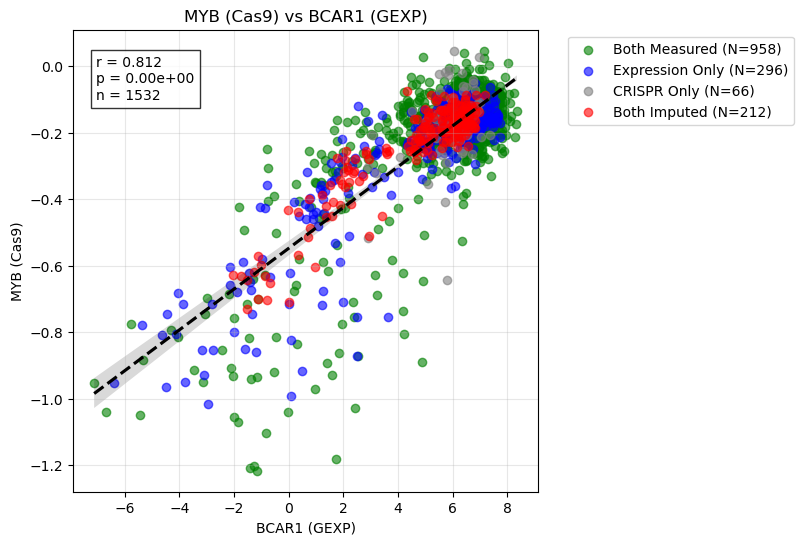

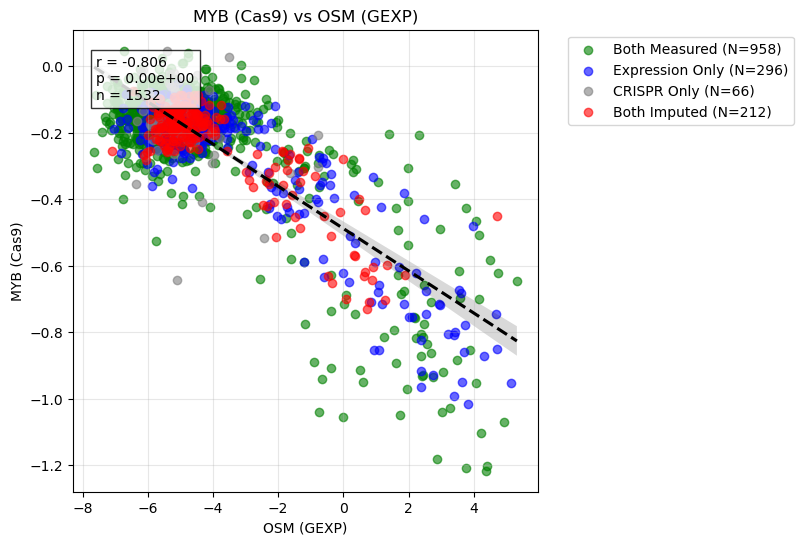

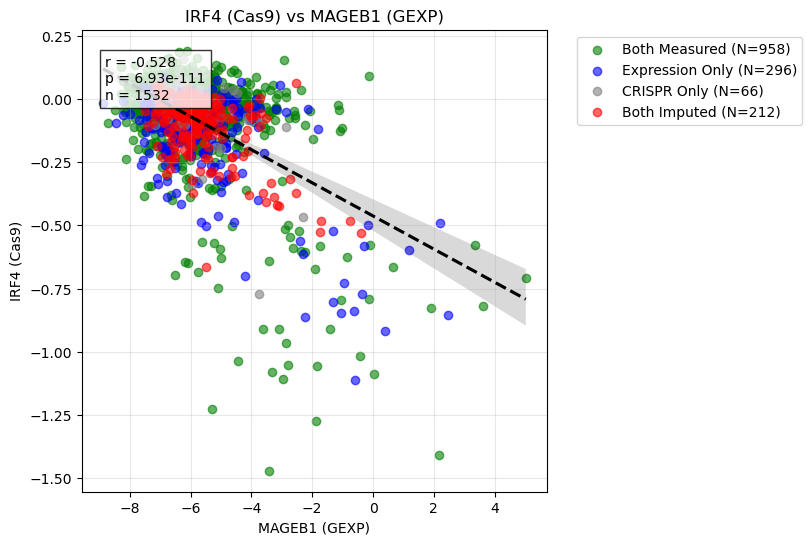

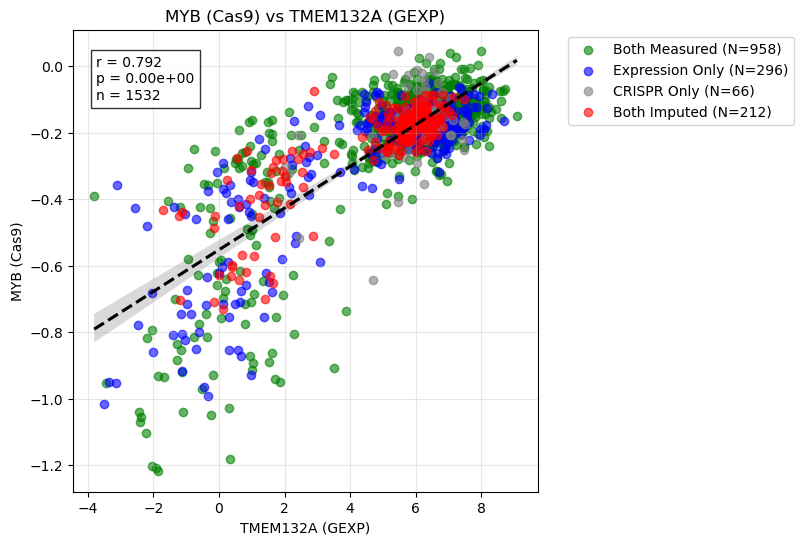

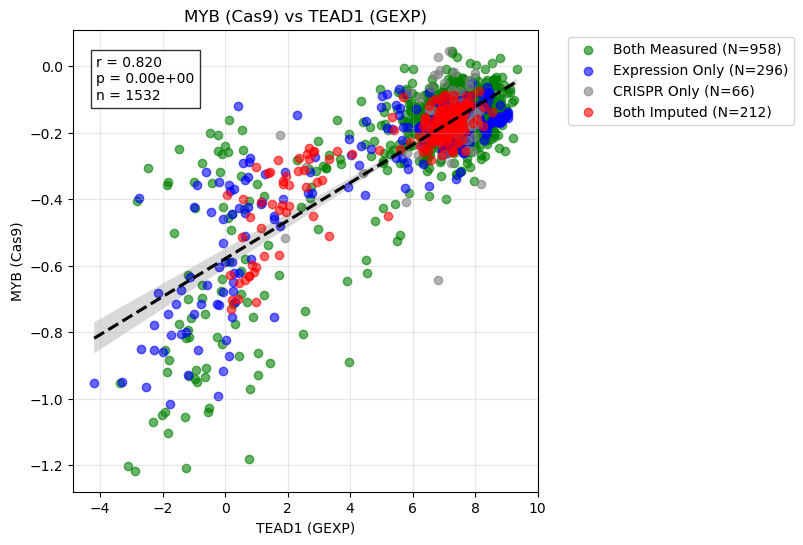

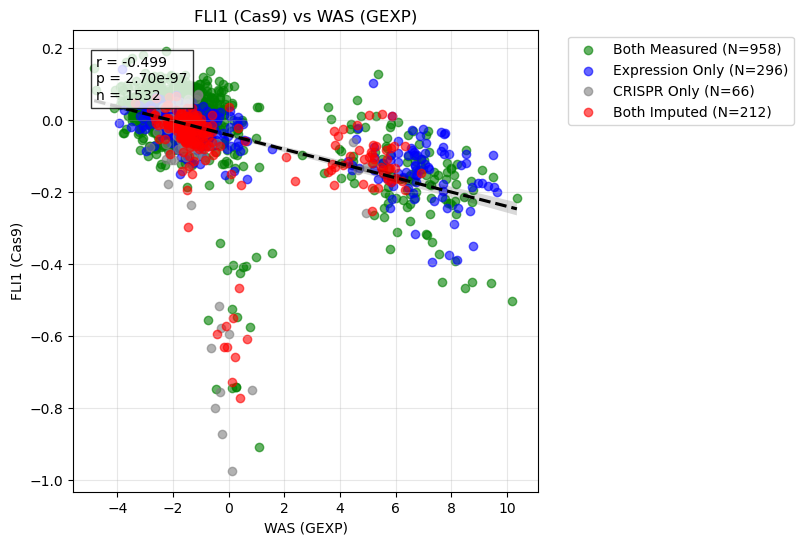

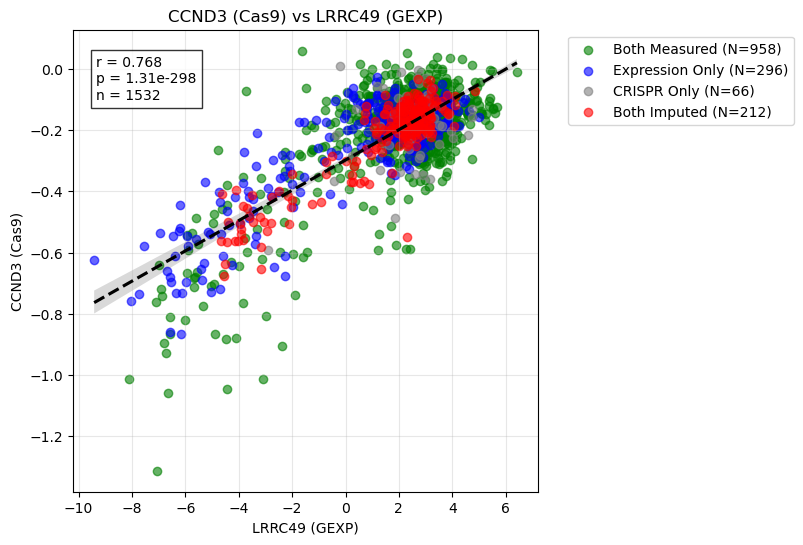

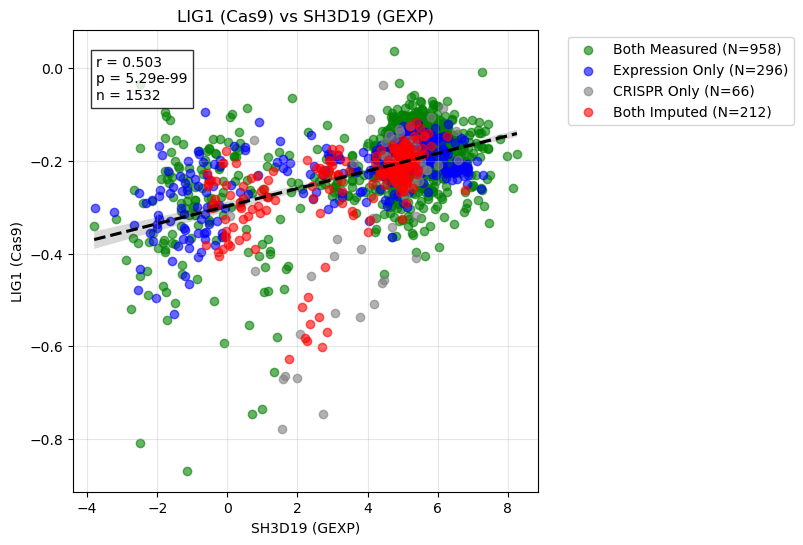

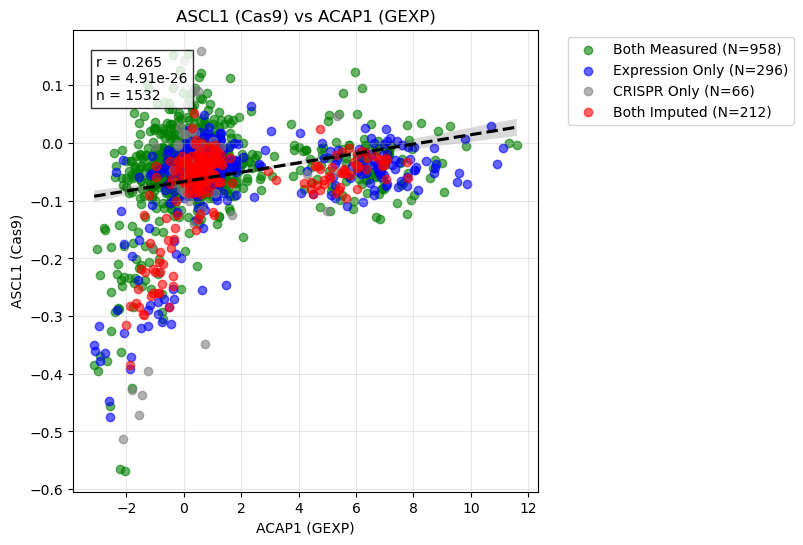

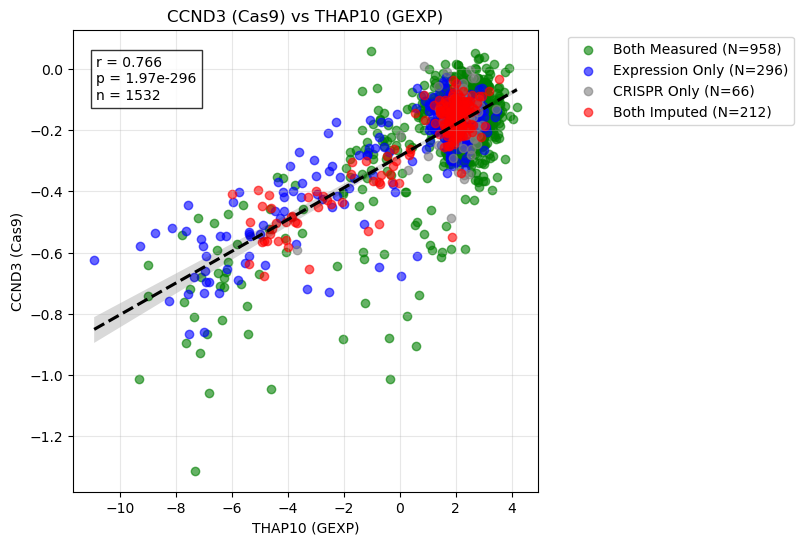

In [35]:
for row in df_res_vae_filtered[COLS].head(10).itertuples():
    plot_scatter(row.y_id, row.x_id, measured_groups=measured_groups, tissue=None, model_list_df=ss_cmp)

In [ ]:
plot_scatter("MYB", "BCAR1", measured_groups=measured_groups, model_list_df=ss_cmp)

# tissue level

In [10]:
df_res_vae = pd.read_csv(
    f"../reports/vae/crispr/{timestamp}_transcriptomics_crisprcas9_tissue.csv.gz"
)


In [11]:
df_res_vae["log10p_orig"] = -np.log10(df_res_vae["pval_orig"])
df_res_vae["log10p_vae"] = -np.log10(df_res_vae["pval_vae"])
df_res_vae["diff_log10p"] = df_res_vae["log10p_vae"] - df_res_vae["log10p_orig"]
df_res_vae["log10fdr_orig"] = -np.log10(df_res_vae["fdr_orig"])
df_res_vae["log10fdr_vae"] = -np.log10(df_res_vae["fdr_vae"])
df_res_vae["diff_log10fdr"] = df_res_vae["log10fdr_vae"] - df_res_vae["log10fdr_orig"]
df_res_vae = df_res_vae.sort_values("diff_log10fdr", ascending=False)

In [12]:
df_res_vae.loc[:,"n_samples_diff"] = (
    df_res_vae["n_samples_vae"] - df_res_vae["n_samples_orig"]
)
df_res_vae.loc[:,"n_samples_diff_pct"] = (
    df_res_vae["n_samples_diff"] / df_res_vae["n_samples_orig"]
)

In [17]:
df_res_vae_filtered = df_res_vae.query("log10fdr_vae > 2 and log10fdr_orig < 2")
df_res_vae_filtered = df_res_vae_filtered[df_res_vae["beta_vae"].abs() > 0.03]
df_res_vae_annot = pd.merge(
    df_res_vae_filtered, skew_df, left_on="y_id", right_index=True
)
df_res_vae_annot = ppi_annotation(df_res_vae_annot, ppi)
# df_res_vae_annot = df_res_vae_annot[
#     df_res_vae_annot["target"].isin(["T", "1", "2", "3", "4", "5"])
# ]
df_res_vae_annot = df_res_vae_annot.query("skew_orig < -2 and skew_mosa < -1.5")

/tmp/ipykernel_2953376/1907296039.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_res_vae_filtered = df_res_vae_filtered[df_res_vae["beta_vae"].abs() > 0.03]
/tmp/ipykernel_2953376/1425643977.py:72: DeprecationWarning: Graph.shortest_paths() is deprecated; use Graph.distances() instead
  c: dict(zip(*(genes, ppi.shortest_paths(source=c, target=genes)[0])))


In [33]:
COLS = ["y_id", "x_id", "beta_orig", "beta_vae", "fdr_orig", "fdr_vae", "diff_log10fdr", "skew_orig", "skew_mosa", "target"]
# df_res_vae_annot[COLS+['tissue']]

In [19]:
df_res_vae_filtered.query("y_id == 'KRAS' and x_id == 'AREG'")

y_id  x_id  n_orig  beta_orig    lr_orig  covs_orig  pval_orig  \
2124380  KRAS  AREG   134.0  -0.030594  18.548767        7.0   0.000017   

         fdr_orig  n_vae  beta_vae     lr_vae  covs_vae      pval_vae  \
2124380  0.019451  257.0 -0.031403  49.627642      11.0  1.858763e-12   

              fdr_vae tissue  n_samples_orig  n_samples_vae  log10p_orig  \
2124380  8.189711e-09   Lung             134            257     4.780907   

         log10p_vae  diff_log10p  log10fdr_orig  log10fdr_vae  diff_log10fdr  \
2124380   11.730776     6.949869       1.711064      8.086731       6.375668   

         n_samples_diff  n_samples_diff_pct  
2124380             123             0.91791

In [20]:
df_res_vae.to_csv(
    f"../reports/vae/crispr/{timestamp}_transcriptomics_crisprcas9_tissue_filtered.csv",
    index=False,
)

In [21]:
df_res_vae = pd.read_csv(
    f"../reports/vae/crispr/{timestamp}_transcriptomics_crisprcas9_tissue_filtered.csv"
)

In [22]:
df_res_vae_annot[COLS + ["tissue"]].to_csv(
    f"../reports/vae/crispr/{timestamp}_transcriptomics_crisprcas9_tissue_filtered_annot.csv", index=None
)

In [23]:
df_res_vae_annot = pd.read_csv(
    f"../reports/vae/crispr/{timestamp}_transcriptomics_crisprcas9_tissue_filtered_annot.csv"
)

In [24]:
df_res_vae[
    ["tissue", "n_samples_orig", "n_samples_diff", "n_samples_diff_pct"]
].drop_duplicates().sort_values("n_samples_diff_pct")

tissue  n_samples_orig  n_samples_diff  \
54325                Biliary Tract              32               3   
15331                      Bladder              34               4   
33288                     Pancreas              43              10   
9637                   Soft Tissue              45              12   
31499                        Ovary              51              15   
44077                    Esophagus              29               9   
49924       Central Nervous System              72              24   
24759                Head and Neck              46              22   
29245              Large Intestine              50              24   
23180                      Stomach              29              15   
6362                        Breast              46              25   
33226    Peripheral Nervous System              29              16   
773                           Skin              56              39   
10795                       Kidney              26              23   
188                           Lung             134             123   
0      Haematopoietic and Lymphoid             116             136   
1942                          Bone              26              35   

       n_samples_diff_pct  
54325            0.093750  
15331            0.117647  
33288            0.232558  
9637             0.266667  
31499            0.294118  
44077            0.310345  
49924            0.333333  
24759            0.478261  
29245            0.480000  
23180            0.517241  
6362             0.543478  
33226            0.551724  
773              0.696429  
10795            0.884615  
188              0.917910  
0                1.172414  
1942             1.346154

In [16]:
df_res_vae[
    ["tissue", "n_samples_orig", "n_samples_diff", "n_samples_diff_pct"]
].drop_duplicates().sort_values("n_samples_diff_pct")

tissue  n_samples_orig  n_samples_diff  \
19                 Biliary Tract              31               4   
54                       Bladder              32               6   
92                      Pancreas              43              10   
159                  Soft Tissue              42              12   
2                      Esophagus              29               9   
763                        Ovary              50              16   
181              Large Intestine              50              24   
641                Head and Neck              45              23   
97                        Breast              44              25   
38                       Stomach              28              16   
218                         Skin              54              40   
31     Peripheral Nervous System              25              20   
48                        Kidney              26              24   
660                         Lung             130             127   
25   Haematopoietic and Lymphoid             104             147   
0                           Bone              24              36   

     n_samples_diff_pct  
19             0.129032  
54             0.187500  
92             0.232558  
159            0.285714  
2              0.310345  
763            0.320000  
181            0.480000  
641            0.511111  
97             0.568182  
38             0.571429  
218            0.740741  
31             0.800000  
48             0.923077  
660            0.976923  
25             1.413462  
0              1.500000

In [17]:
df_res_vae_annot['target'].value_counts()

target
-     471
5+    235
4     133
3      65
2       9
1       2
T       1
Name: count, dtype: int64

In [ ]:
for row in df_res_vae_annot.head(10).itertuples():
    plot_scatter(row.y_id, row.x_id, measured_groups=measured_groups, tissue=row.tissue, model_list_df=ss_cmp)

# Filtering for Dave

In [21]:
gene_list_df = pd.read_excel("../data/FINAL list of FUR driver genes_15th_Feb_25 copy.xlsx")
gene_list_df.head()
gene_names_list = gene_list_df["Gene name"].drop_duplicates().dropna().to_list()
len(gene_names_list)

31

## pop corrected

In [22]:
# df_res_vae_annot = pd.read_csv(
#     f"../reports/vae/crispr/{timestamp}_transcriptomics_crisprcas9_annot.csv.gz",index_col=0
# )

# df_res_vae_annot = pd.read_csv(
#     f"../reports/vae/crispr/{timestamp}_transcriptomics_crisprcas9_annot_popcorrected.csv.gz",
#     index_col=0,
# )

df_res_vae_annot = pd.read_csv(
    f"../reports/vae/crispr/{timestamp}_transcriptomics_crisprcas9_remove_latent_n3_no_tissue_standardizedTrue_annot.csv.gz"
)

In [23]:
df_res_vae_annot.head()

y_id   x_id  n_orig  beta_orig     lr_orig  covs_orig     pval_orig  \
0  SOX10  SOX10   965.0  -0.297399   64.155412      208.0  1.149817e-15   
1   PAX3   G2E3   965.0   0.380405  116.253804      208.0  4.182009e-27   
2   ITPA   PUDP   965.0   0.412241  184.978354      208.0  3.967560e-42   
3  SOX10    MIA   965.0  -0.164327   32.405766      208.0  1.251147e-08   
4  MYOD1   MYOG   965.0  -0.406458  119.579137      208.0  7.821206e-28   

       fdr_orig   n_vae  beta_vae      lr_vae  covs_vae      pval_vae  \
0  1.964922e-11  1532.0 -0.349686  182.407632     211.0  1.444626e-41   
1  7.146636e-23  1532.0  0.362160  183.536329     211.0  8.190998e-42   
2  6.780163e-38  1532.0  0.383650  248.736601     211.0  4.896377e-56   
3  1.069042e-04  1532.0 -0.202882   89.784351     211.0  2.655868e-21   
4  1.336566e-23  1532.0 -0.384581  174.104365     211.0  9.392760e-40   

        fdr_vae  log10p_orig  log10p_vae  diff_log10p  skew_orig  skew_mosa  \
0  5.340783e-38    14.939371   40.840244    25.900873  -3.759395  -3.511710   
1  3.028212e-38    26.378615   41.086663    14.708048  -4.230929  -2.990549   
2  1.810191e-52    41.401477   55.310125    13.908649  -2.738492  -0.852859   
3  9.818743e-18     7.902692   20.575794    12.673102  -3.759395  -3.511710   
4  3.472503e-36    27.106726   39.027207    11.920480  -4.974084  -3.993729   

                target_detailed target   entropy  
0                             T      T  0.790358  
1  No link; Gene not in network      -  0.449509  
2        No link; No connection      -  0.272488  
3  No link; Gene not in network      -  0.790358  
4                             2      2  0.154927

In [170]:
from statsmodels.stats.multitest import multipletests

# Group by y_id and apply BH correction separately for each group
result_dfs = []
for y_id, group in df_res_vae_annot.groupby("y_id"):
    # Apply BH correction for original p-values
    _, fdr_orig, _, _ = multipletests(group["pval_orig"], method="fdr_bh")
    group_copy = group.copy()
    group_copy["fdr_orig"] = fdr_orig

    # Apply BH correction for VAE p-values
    _, fdr_vae, _, _ = multipletests(group["pval_vae"], method="fdr_bh")
    group_copy["fdr_vae"] = fdr_vae

    result_dfs.append(group_copy)

# Combine all corrected groups back into a single DataFrame
df_res_vae_annot_corrected = pd.concat(result_dfs)

# Either assign back to original variable or use new variable
# df_res_vae_annot = df_res_vae_annot_corrected

In [24]:
df_res_vae_annot["log10fdr_orig"] = -np.log10(df_res_vae_annot["fdr_orig"])
df_res_vae_annot["log10fdr_vae"] = -np.log10(df_res_vae_annot["fdr_vae"])
df_res_vae_annot["diff_log10fdr"] = (
    df_res_vae_annot["log10fdr_vae"] - df_res_vae_annot["log10fdr_orig"]
)

Text(0.5, 1.0, 'CTNNB1')

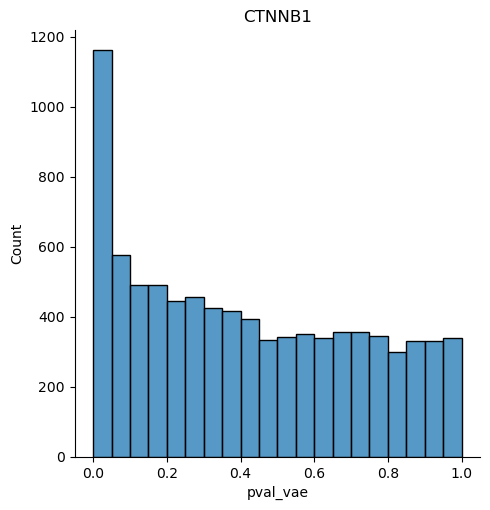

In [25]:
sns.displot(df_res_vae_annot[df_res_vae_annot["y_id"] == "CTNNB1"]["pval_vae"])
plt.title("CTNNB1")

In [78]:
# df_res_vae_filtered = df_res_vae_annot.query("log10fdr_vae > 2")
# df_res_vae_filtered = df_res_vae_filtered.query("log10fdr_orig < 2")
df_res_vae_filtered = df_res_vae_annot[df_res_vae_annot["beta_vae"] > 0]
# df_res_vae_filtered = df_res_vae_filtered.query("log10fdr_vae > 2")

# df_res_vae_filtered = df_res_vae_filtered[df_res_vae_filtered["target"].isin(['T', '1', '2', '3','4','5'])]
# df_res_vae_filtered = df_res_vae_filtered.query("skew_orig < -2 and skew_mosa < -2")

In [79]:
df_res_vae_filtered.head()

y_id   x_id  n_orig  beta_orig     lr_orig  covs_orig     pval_orig  \
1   PAX3   G2E3   965.0   0.380405  116.253804      208.0  4.182009e-27   
2   ITPA   PUDP   965.0   0.412241  184.978354      208.0  3.967560e-42   
5  EFR3A  EFR3B   965.0   0.545849  223.702252      208.0  1.408828e-50   
6  NAA10  NAA11   965.0   0.567211  312.255612      208.0  7.044668e-70   
8   MYOG   G2E3   965.0   0.356539   85.197391      208.0  2.700179e-20   

       fdr_orig   n_vae  beta_vae      lr_vae  covs_vae      pval_vae  \
1  7.146636e-23  1532.0  0.362160  183.536329     211.0  8.190998e-42   
2  6.780163e-38  1532.0  0.383650  248.736601     211.0  4.896377e-56   
5  2.407546e-46  1532.0  0.474253  278.197209     211.0  1.855496e-62   
6  1.203863e-65  1532.0  0.485253  364.441030     211.0  3.037936e-81   
8  2.307168e-16  1532.0  0.333121  132.831296     211.0  9.843062e-31   

        fdr_vae  log10p_orig  log10p_vae  diff_log10p  skew_orig  skew_mosa  \
1  3.028212e-38    26.378615   41.086663    14.708048  -4.230929  -2.990549   
2  1.810191e-52    41.401477   55.310125    13.908649  -2.738492  -0.852859   
5  6.859767e-59    49.851142   61.731540    11.880398  -0.731342  -0.435528   
6  1.123125e-77    69.152139   80.517421    11.365282   1.096267   1.159434   
8  1.819490e-27    19.568607   30.006870    10.438262  -5.511541  -2.911290   

                  target_detailed target   entropy  log10fdr_orig  \
1    No link; Gene not in network      -  0.449509      22.145898   
2          No link; No connection      -  0.272488      37.168760   
5  No link; CRISPR not in network      -  0.848958      45.618425   
6                               1      1  0.864291      64.919423   
8    No link; Gene not in network      -  0.096860      15.636921   

   log10fdr_vae  diff_log10fdr  
1     37.518814      15.372915  
2     51.742276      14.573516  
5     58.163691      12.545265  
6     76.949572      12.030149  
8     26.740050      11.103130

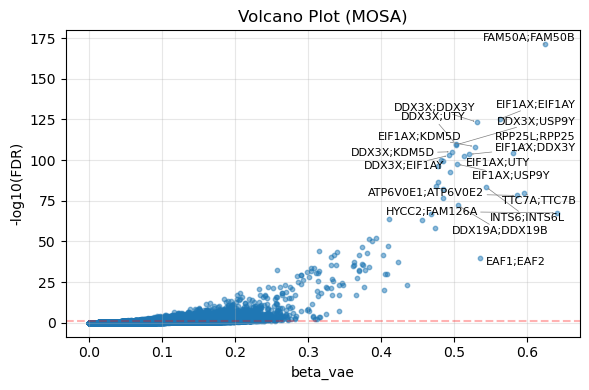

In [27]:
plot_volcano(
    df=df_res_vae_filtered,
    beta_col="beta_vae",
    log10fdr_col="log10fdr_vae",
    beta_threshold=0.5,
    fdr_threshold=100,
    title="Volcano Plot (MOSA)",
)

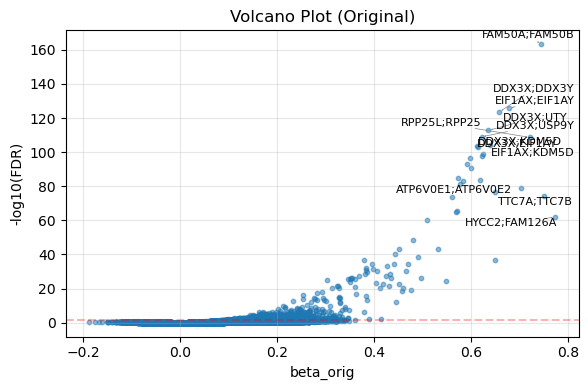

In [69]:
plot_volcano(
    df=df_res_vae_filtered,
    beta_col="beta_orig",
    log10fdr_col="log10fdr_orig",
    beta_threshold=0.7,
    fdr_threshold=100,
    title="Volcano Plot (Original)",
)

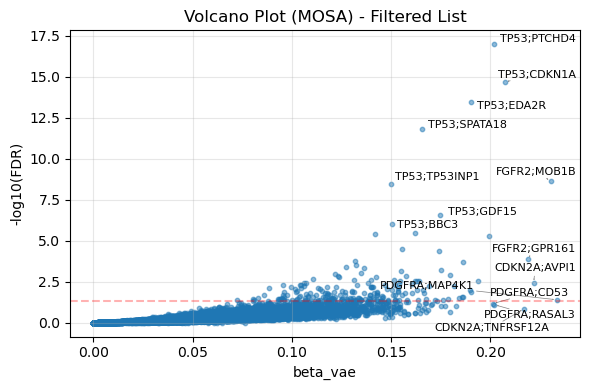

In [28]:
plot_volcano(
    df=df_res_vae_filtered[df_res_vae_filtered["y_id"].isin(gene_names_list)],
    beta_col="beta_vae",
    log10fdr_col="log10fdr_vae",
    beta_threshold=0.2,
    fdr_threshold=6,
    title="Volcano Plot (MOSA) - Filtered List",
)

In [80]:
df_res_vae_filtered.sort_values("log10fdr_vae", ascending=False).head(10)

y_id    x_id  n_orig  beta_orig     lr_orig  covs_orig  \
91        FAM50A  FAM50B   965.0   0.746732  773.480639      208.0   
30183993  EIF1AX  EIF1AY   965.0   0.687963  609.029710      208.0   
30183972   DDX3X   DDX3Y   965.0   0.662942  594.705584      208.0   
30183998   DDX3X     UTY   965.0   0.638485  545.359281      208.0   
30183981   DDX3X   USP9Y   965.0   0.630518  531.960578      208.0   
30183194  EIF1AX   KDM5D   965.0   0.650422  518.912303      208.0   
30183265   DDX3X   KDM5D   965.0   0.625017  503.332032      208.0   
30183990  RPP25L   RPP25   965.0   0.719519  511.269764      208.0   
29995834  EIF1AX   DDX3Y   965.0   0.634019  489.264486      208.0   
30183187   DDX3X  EIF1AY   965.0   0.620201  493.135040      208.0   

              pval_orig       fdr_orig   n_vae  beta_vae      lr_vae  \
91        3.147523e-170  5.378802e-166  1532.0  0.624528  797.607890   
30183993  1.818819e-134  3.108179e-130  1532.0  0.562476  586.119516   
30183972  2.373477e-131  4.056034e-127  1532.0  0.531745  577.080647   
30183998  1.286894e-120  2.199174e-116  1532.0  0.502321  515.797782   
30183981  1.057830e-117  1.807726e-113  1532.0  0.503008  513.374213   
30183194  7.297686e-115  1.247102e-110  1532.0  0.528597  508.040847   
30183265  1.790573e-111  1.529955e-107  1532.0  0.496678  492.348631   
30183990  3.356998e-113  5.736773e-109  1532.0  0.581092  489.859720   
29995834  2.059927e-108  1.760105e-104  1532.0  0.520443  484.930156   
30183187  2.962562e-109  2.531361e-105  1532.0  0.492937  482.278222   

          covs_vae       pval_vae        fdr_vae  log10p_orig  log10p_vae  \
91           211.0  1.787104e-175  6.606925e-172   169.502031  174.747850   
30183993     211.0  1.749740e-129  6.468788e-126   133.740211  128.757027   
30183972     211.0  1.618461e-127  5.983451e-124   130.624615  126.790898   
30183998     211.0  3.473738e-114  1.284241e-110   119.890457  113.459203   
30183981     211.0  1.169734e-113  4.324508e-110   116.975584  112.931913   
30183194     211.0  1.692278e-112  6.256353e-109   114.136815  111.771528   
30183265     211.0  4.393183e-109  8.120799e-106   110.747008  108.357221   
30183990     211.0  1.528747e-108  5.651776e-105   112.474049  107.815664   
29995834     211.0  1.807025e-107  3.340285e-104   107.686148  106.743036   
30183187     211.0  6.823545e-107  1.261332e-103   108.528333  106.165990   

          diff_log10p  skew_orig  skew_mosa                 target_detailed  \
91           5.245819  -0.636418  -0.348054  No link; CRISPR not in network   
30183993    -4.983184   0.619081  -0.181497                               1   
30183972    -3.833717   0.538874  -0.280083                               3   
30183998    -6.431254   0.538874  -0.280083                               3   
30183981    -4.043671   0.538874  -0.280083                               3   
30183194    -2.365287   0.619081  -0.181497                               2   
30183265    -2.389787   0.538874  -0.280083                               3   
30183990    -4.658384  -1.612328  -0.454558                               1   
29995834    -0.943112   0.619081  -0.181497                               2   
30183187    -2.362343   0.538874  -0.280083                               2   

         target   entropy  log10fdr_orig  log10fdr_vae  diff_log10fdr  
91            -  0.856258     165.269314    171.180001       5.910686  
30183993      1  0.863994     129.507494    125.189177      -4.318317  
30183972      3  0.863918     126.391898    123.223048      -3.168850  
30183998      3  0.863918     115.657740    109.891354      -5.766387  
30183981      3  0.863918     112.742867    109.364063      -3.378804  
30183194      2  0.863994     109.904098    108.203679      -1.700419  
30183265      3  0.863918     106.815321    105.090401      -1.724920  
30183990      1  0.842598     108.241332    104.247815      -3.993517  
29995834      2  0.863994     103.754461    103.476216      -0.278245  
30183187  

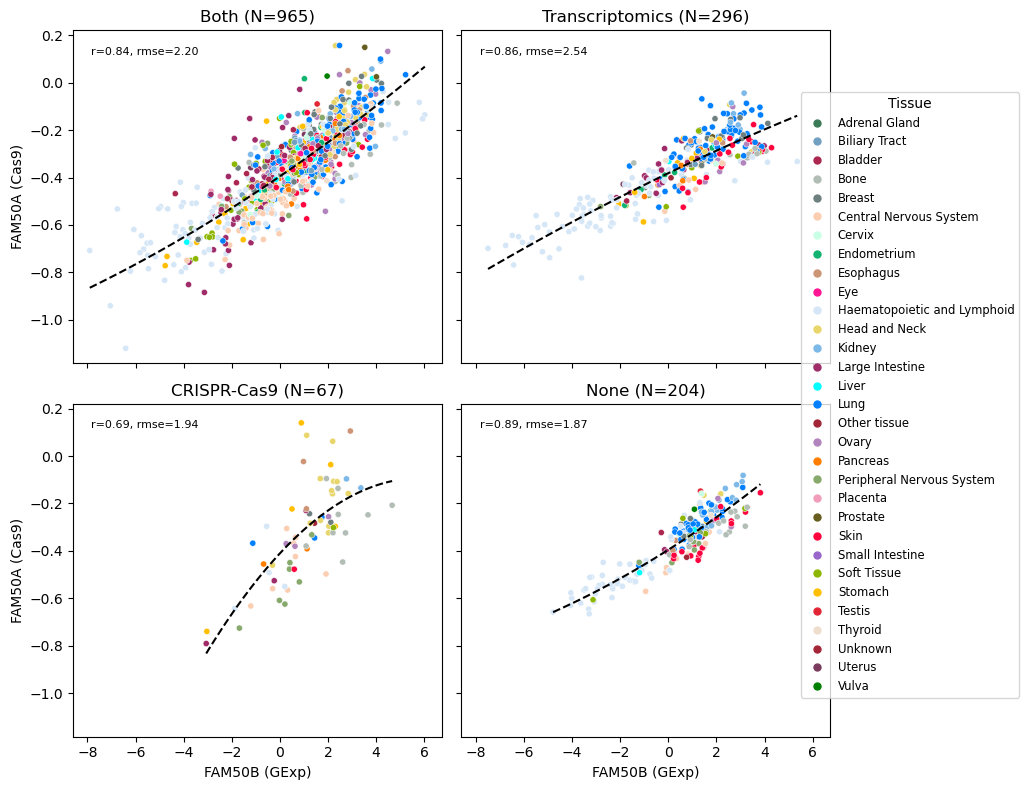

In [74]:
fig = plot_cas9_vs_gexp_comparison(
    cas9_id="FAM50A",
    gexp_id="FAM50B",
    cas9_df=cas9_df,
    gexp_df=gexp_df,
    measured_groups=measured_groups,
    tissue_map=tissue_map
)
plt.show()

In [30]:
df_res_vae_filtered = df_res_vae_filtered.query("log10fdr_vae > 1")
df_res_vae_filtered.shape

(55376, 24)

In [31]:
df_res_vae_filtered.groupby("y_id").size().sort_values(ascending=False)

y_id
DENND4A     161
SH3GL1      156
POU2AF1     129
CYB561A3    128
TIMM10B     124
           ... 
LLPH          1
IDI1          1
PIGW          1
IFNGR1        1
ANAPC10       1
Length: 3516, dtype: int64

In [84]:
df_res_vae_filtered.to_csv(
    f"../reports/vae/crispr/{timestamp}_transcriptomics_crisprcas9_popcorrected_latent_filtered.csv",
    index=False,
)

In [34]:
df_final = df_res_vae_filtered[df_res_vae_filtered["y_id"].isin(gene_names_list)]
df_final = df_final.sort_values("log10fdr_vae", ascending=False)

In [35]:
df_final[COLS]['y_id'].nunique()

17

In [36]:
df_final.shape

(394, 24)

In [37]:
df_final[COLS].head()

y_id     x_id  beta_orig  beta_vae      fdr_orig       fdr_vae  \
144   TP53   PTCHD4   0.217678  0.201990  1.054904e-11  1.078019e-17   
216   TP53   CDKN1A   0.204204  0.207265  3.114466e-08  2.114754e-15   
325   TP53    EDA2R   0.181044  0.190323  2.505448e-06  3.763334e-14   
199   TP53  SPATA18   0.180868  0.165365  1.080415e-08  1.523833e-12   
313  FGFR2    MOB1B   0.262460  0.230482  1.375092e-06  2.340147e-09   

     diff_log10fdr  skew_orig  skew_mosa target  
144       5.990587   2.300810   1.306683      -  
216       7.168124   2.300810   1.306683      1  
325       7.823313   2.300810   1.306683      2  
199       3.850653   2.300810   1.306683      -  
313       2.769089  -6.377473  -3.526639      4

In [38]:
df_final_formatted = df_final[COLS]
# Rename columns from "_vae" to "_mosa" using a more succinct approach
df_final_formatted = df_final_formatted.rename(columns={col: col.replace('_vae', '_mosa') for col in df_final_formatted.columns if '_vae' in col})
# Rename y_id to crispr_gene and x_id to rna_gene
df_final_formatted = df_final_formatted.rename(columns={'y_id': 'crispr_gene', 'x_id': 'rna_gene'})

In [39]:
df_final_formatted.groupby("crispr_gene").size().sort_values(ascending=False)

crispr_gene
IKZF3     51
TP53      43
CDKN2A    40
CTNNB1    36
FGFR2     33
PDGFRA    24
FBXW7     22
PTPN11    20
TGFBR1    18
PIK3CA    18
RPL22     15
NF1       15
APC       14
PTEN      14
PIK3R1    13
TRAF3     11
MAP2K1     7
dtype: int64

In [40]:
df_final_formatted.to_csv(
    f"../reports/vae/crispr/crisprcas9_transcriptomics_SL_pairs_Dave_{timestamp}_all_latent_covariate.csv",
    index=False,
)

In [ ]:
df_final_formatted = pd.read_csv(
    f"../reports/vae/crispr/crisprcas9_transcriptomics_SL_pairs_Dave_{timestamp}_all_latent_covariate.csv",
)
df_final_formatted.groupby("crispr_gene").size().sort_values(ascending=False)

In [82]:
df_final_formatted.shape

(31, 10)

## no pop correction

In [16]:
df_res_vae_annot = pd.read_csv(
    f"../reports/vae/crispr/{timestamp}_transcriptomics_crisprcas9_annot.csv.gz",index_col=0
)

# df_res_vae_annot = pd.read_csv(
#     f"../reports/vae/crispr/{timestamp}_transcriptomics_crisprcas9_annot_popcorrected.csv.gz",
#     index_col=0,
# )

In [17]:
df_res_vae_annot["log10fdr_orig"] = -np.log10(df_res_vae_annot["fdr_orig"])
df_res_vae_annot["log10fdr_vae"] = -np.log10(df_res_vae_annot["fdr_vae"])
df_res_vae_annot["diff_log10fdr"] = (
    df_res_vae_annot["log10fdr_vae"] - df_res_vae_annot["log10fdr_orig"]
)

Text(0.5, 1.0, 'CTNNB1')

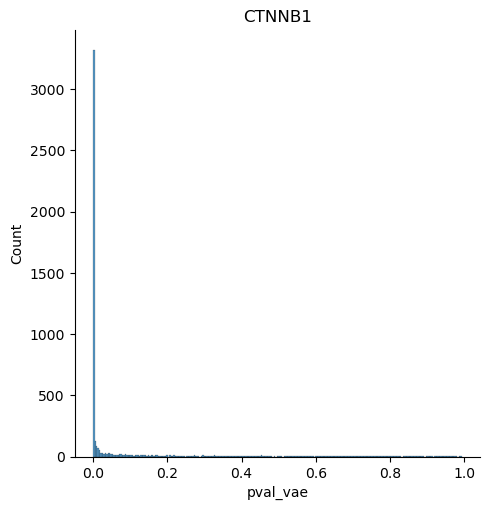

In [19]:
sns.displot(df_res_vae_annot[df_res_vae_annot["y_id"] == "CTNNB1"]["pval_vae"])
plt.title("CTNNB1")

In [23]:
# df_res_vae_filtered = df_res_vae_annot.query("log10fdr_vae > 2")
# df_res_vae_filtered = df_res_vae_filtered.query("log10fdr_orig < 2")
df_res_vae_filtered = df_res_vae_annot[df_res_vae_annot["beta_vae"] > 0]
# df_res_vae_filtered = df_res_vae_filtered.query("log10fdr_vae > 2 or log10fdr_vae > 2")

# df_res_vae_filtered = df_res_vae_filtered[df_res_vae_filtered["target"].isin(['T', '1', '2', '3','4','5'])]
# df_res_vae_filtered = df_res_vae_filtered.query("skew_orig < -2 and skew_mosa < -2")

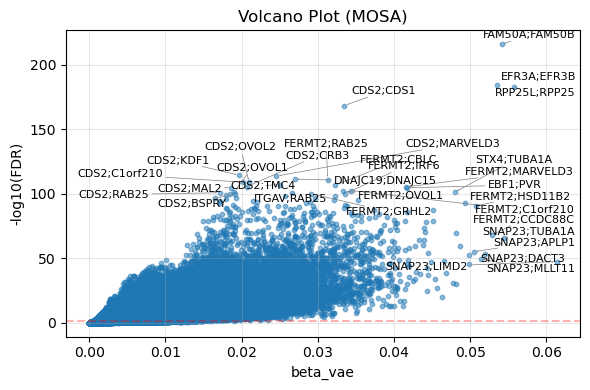

In [46]:
plot_volcano(
    df=df_res_vae_filtered,
    beta_col="beta_vae",
    log10fdr_col="log10fdr_vae",
    beta_threshold=0.05,
    fdr_threshold=100,
    title="Volcano Plot (MOSA)",
)

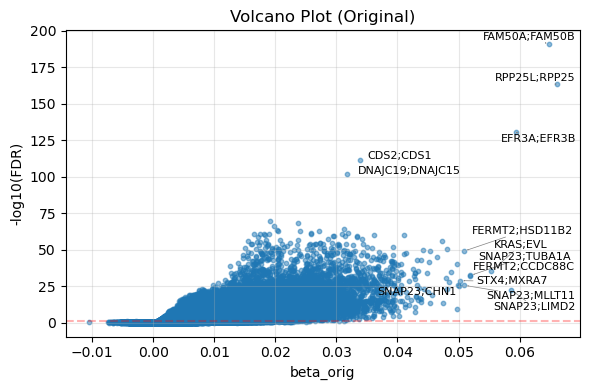

In [45]:
plot_volcano(
    df=df_res_vae_filtered,
    beta_col="beta_orig",
    log10fdr_col="log10fdr_orig",
    beta_threshold=0.05,
    fdr_threshold=75,
    title="Volcano Plot (Original)",
)

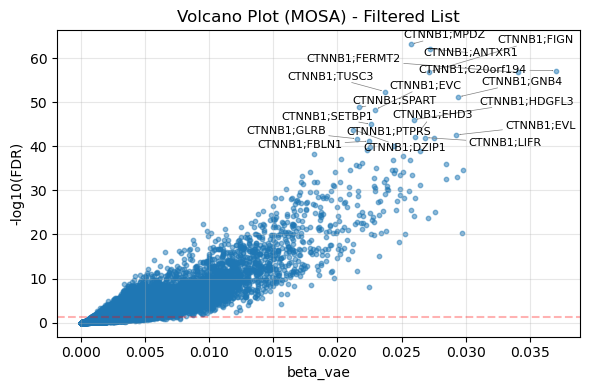

In [47]:
plot_volcano(
    df=df_res_vae_filtered[df_res_vae_filtered["y_id"].isin(gene_names_list)],
    beta_col="beta_vae",
    log10fdr_col="log10fdr_vae",
    beta_threshold=0.03,
    fdr_threshold=40,
    title="Volcano Plot (MOSA) - Filtered List",
)

In [24]:
df_res_vae_filtered = df_res_vae_filtered.query("log10fdr_vae > 2 or log10fdr_vae > 2")

In [25]:
df_final = df_res_vae_filtered[df_res_vae_filtered["y_id"].isin(gene_names_list)]
df_final = df_final.sort_values("log10fdr_vae", ascending=False)

In [26]:
df_final[COLS]['y_id'].nunique()

16

In [27]:
df_final[COLS].head()

y_id       x_id  beta_orig  beta_vae      fdr_orig       fdr_vae  \
1444  CTNNB1       MPDZ   0.025523  0.025730  3.717732e-34  7.178695e-64   
886   CTNNB1     ANTXR1   0.029695  0.027244  4.338352e-39  8.559696e-63   
1025  CTNNB1  C20orf194   0.042590  0.037058  1.446819e-37  6.964004e-58   
1799  CTNNB1       FIGN   0.027413  0.027172  6.414318e-32  1.317033e-57   
1309  CTNNB1     FERMT2   0.037542  0.034069  4.433460e-35  1.761504e-57   

      diff_log10fdr  skew_orig  skew_mosa target  
1444      29.714233  -3.138647  -2.848644      3  
886       23.704866  -3.138647  -2.848644      -  
1025      20.317555  -3.138647  -2.848644      -  
1799      25.687554  -3.138647  -2.848644      -  
1309      22.400859  -3.138647  -2.848644      2

In [28]:
df_final_formatted = df_final[COLS]
# Rename columns from "_vae" to "_mosa" using a more succinct approach
df_final_formatted = df_final_formatted.rename(columns={col: col.replace('_vae', '_mosa') for col in df_final_formatted.columns if '_vae' in col})
# Rename y_id to crispr_gene and x_id to rna_gene
df_final_formatted = df_final_formatted.rename(columns={'y_id': 'crispr_gene', 'x_id': 'rna_gene'})

In [29]:
df_final_formatted.groupby("crispr_gene").size().sort_values(ascending=False)

crispr_gene
CTNNB1     1963
PIK3CA     1190
PDGFRA      839
IKZF3       730
FBXW7       667
MAP2K1      429
TNFAIP3     374
PIK3R1      369
CASP8       299
FGFR2       248
RARA        141
TGFBR1      141
KIT         130
NOTCH1      109
MSH2         47
ACVR1B       33
dtype: int64

In [ ]:
df_final_formatted = pd.read_csv(
    "../reports/vae/crispr/crisprcas9_transcriptomics_SL_pairs_Dave_20250225_145621.csv"
)
df_final_formatted.groupby("crispr_gene").size().sort_values(ascending=False)

crispr_gene
CTNNB1     1963
PIK3CA     1190
PDGFRA      839
IKZF3       730
FBXW7       667
MAP2K1      429
TNFAIP3     374
PIK3R1      369
CASP8       299
FGFR2       248
RARA        141
TGFBR1      141
KIT         130
NOTCH1      109
MSH2         47
ACVR1B       33
dtype: int64

In [ ]:
df_final_formatted.to_csv(
    f"../reports/vae/crispr/crisprcas9_transcriptomics_SL_pairs_Dave_{timestamp}_popcorrected.csv",
    index=False,
)

# validation score

In [21]:
df_res_vae_annot = pd.read_csv(
    f"../reports/vae/crispr/{timestamp}_transcriptomics_crisprcas9_remove_latent_n3_no_tissue_standardizedTrue_annot.csv.gz"
)

In [53]:
df_res_vae_annot.head()

y_id    x_id  n_orig  beta_orig    lr_orig  covs_orig      pval_orig  \
0  FAM50A  FAM50B   965.0    0.74673  773.48064      208.0  3.147523e-170   
1  EIF1AX  EIF1AY   965.0    0.68796  609.02971      208.0  1.818819e-134   
2   DDX3X   DDX3Y   965.0    0.66294  594.70558      208.0  2.373477e-131   
3   DDX3X     UTY   965.0    0.63849  545.35928      208.0  1.286894e-120   
4   DDX3X   USP9Y   965.0    0.63052  531.96058      208.0  1.057830e-117   

        fdr_orig   n_vae  beta_vae     lr_vae  covs_vae       pval_vae  \
0  5.378802e-166  1532.0   0.62453  797.60789     211.0  1.787104e-175   
1  3.108179e-130  1532.0   0.56248  586.11952     211.0  1.749740e-129   
2  4.056034e-127  1532.0   0.53175  577.08065     211.0  1.618461e-127   
3  2.199174e-116  1532.0   0.50232  515.79778     211.0  3.473738e-114   
4  1.807726e-113  1532.0   0.50301  513.37421     211.0  1.169734e-113   

         fdr_vae  skew_orig  skew_mosa                 target_detailed target  \
0  6.606925e-172   -0.63194   -0.34805  No link; CRISPR not in network      -   
1  6.468788e-126    0.61614   -0.18150                               1      1   
2  5.983451e-124    0.53787   -0.28008                               3      3   
3  1.284241e-110    0.53787   -0.28008                               3      3   
4  4.324508e-110    0.53787   -0.28008                               3      3   

   entropy  
0  0.82357  
1  0.83241  
2  0.83244  
3  0.83244  
4  0.83244

In [56]:
df_res_vae_annot["log10fdr_orig"] = -np.log10(df_res_vae_annot["fdr_orig"])
df_res_vae_annot["log10fdr_vae"] = -np.log10(df_res_vae_annot["fdr_vae"])
df_res_vae_annot["diff_log10fdr"] = (
    df_res_vae_annot["log10fdr_vae"] - df_res_vae_annot["log10fdr_orig"]
)
df_res_vae_filtered = df_res_vae_annot[df_res_vae_annot["beta_vae"] > 0]
# df_res_vae_filtered = df_res_vae_filtered.query("log10fdr_vae > 3 and log10fdr_orig < 3")
df_res_vae_filtered = df_res_vae_filtered.query(
    "log10fdr_vae > 2"
)

# df_res_vae_filtered = df_res_vae_filtered.query("skew_orig < -1.5 and skew_mosa < -1.5")
df_res_vae_filtered["corr_raw"] = df_res_vae_filtered.apply(calculate_pearson_r, axis=1)
df_res_vae_filtered = df_res_vae_filtered.query("corr_raw > 0.3")
df_res_vae_filtered = df_res_vae_filtered.reset_index(drop=True)

In [64]:
df_res_vae_filtered_delta = df_res_vae_filtered.query(
    "log10fdr_vae > 3 and log10fdr_orig < 3 and entropy > 0.7 and corr_raw > 0.5"
).sort_values("diff_log10fdr", ascending=False)
df_res_vae_filtered_delta

y_id      x_id  n_orig  beta_orig   lr_orig  covs_orig     pval_orig  \
1306  CHMP4B      CRB3   965.0    0.22707  12.66755      208.0  3.720577e-04   
634     IPPK      GJA1   965.0    0.17047  18.13655      208.0  2.056170e-05   
784     CDS2     BSPRY   965.0    0.20648  18.50882      208.0  1.691200e-05   
610     PGM3      GJA1   965.0    0.16206  18.48474      208.0  1.712703e-05   
1305   SOX10    OCIAD2   965.0    0.09366  13.02046      208.0  3.081065e-04   
1053   DTYMK      GJA1   965.0    0.14796  14.33238      208.0  1.532065e-04   
410     PFAS      GJC1   965.0    0.17920  21.67388      208.0  3.231615e-06   
409    NAMPT      GJC1   965.0    0.17875  21.48476      208.0  3.566517e-06   
1459    CDS2      TMC4   965.0    0.17021   9.00328      208.0  2.694957e-03   
1035  CHMP4B     PTPN6   965.0    0.18784  15.35484      208.0  8.909236e-05   
755     GMPS      GJA1   965.0    0.14659  16.40693      208.0  5.109799e-05   
1424    CDS2  MARVELD3   965.0    0.18174   9.66818      208.0  1.874871e-03   
446     CDS2  MARVELD2   965.0    0.23804  22.89180      208.0  1.713814e-06   
788    EFR3A      CHRD   965.0    0.13232  16.61915      208.0  4.568748e-05   
378     PFAS     TRNP1   965.0    0.19953  22.80457      208.0  1.793384e-06   
377     ATIC     TRNP1   965.0    0.20490  24.81146      208.0  6.322038e-07   
1054    ATIC      GJA1   965.0    0.13178  14.23928      208.0  1.609750e-04   
478     PPAT      GJC1   965.0    0.16877  19.58697      208.0  9.612248e-06   
1055    AHCY      GJA1   965.0    0.14584  13.75221      208.0  2.085755e-04   
1157   PSMB5     PSMB8   965.0    0.16989  13.57256      208.0  2.295158e-04   
923    THAP1     PSMB8   965.0    0.20093  15.33038      208.0  9.025354e-05   
1444    DLST      GJA1   965.0    0.09995   8.03926      208.0  4.577432e-03   
1203    GART      GJC1   965.0    0.13434  13.33363      208.0  2.606884e-04   
1494    CDS2      KDF1   965.0    0.19036   9.46024      208.0  2.099741e-03   
1056    ACO2      GJA1   965.0    0.14288  14.02942      208.0  1.799724e-04   
1173   GFPT1     GFPT2   965.0    0.16147  14.63294      208.0  1.306117e-04   
599     STX4     KIF3C   965.0    0.18958  21.99010      208.0  2.740598e-06   
666   STXBP3     NXPE3   965.0    0.18081  22.51215      208.0  2.088188e-06   
333    THAP1    CHMP4A   965.0    0.17005  23.63676      208.0  1.163435e-06   
746   FERMT2   TMEM238   965.0    0.19219  19.72523      208.0  8.941287e-06   
386     PFAS    FBXO17   965.0    0.17491  23.11001      208.0  1.529921e-06   
1341  CHMP4B   DENND1C   965.0    0.17880  12.51848      208.0  4.029472e-04   
683     KRAS       EVL   965.0    0.15942  18.66855      208.0  1.555271e-05   
544     IPPK   HSPA12A   965.0    0.18595  19.80454      208.0  8.577859e-06   
781   ACTL6A     AMER3   965.0    0.21905  20.68855      208.0  5.403824e-06   
702   STXBP3     KIF3C   965.0    0.19557  19.16081      208.0  1.201550e-05   
738    GFPT1     FOXF1   965.0    0.16906  21.36055      208.0  3.805214e-06   
522    NAA10     PAGE2   965.0    0.15996  23.38411      208.0  1.326696e-06   
792   CHMP4B      EVPL   965.0    0.20101  17.62667      208.0  2.687920e-05   
688     TUBB   CEACAM5   965.0    0.22369  22.35007      208.0  2.272045e-06   
398    ITGAV     PTAFR   965.0    0.19857  24.49779      208.0  7.439527e-07   
374     GRK2   KATNAL2   965.0    0.19335  25.00439      208.0  5.719997e-07   
286   EEFSEC     AIFM2   965.0    0.18438  24.01037      208.0  9.581836e-07   

      fdr_orig   n_vae  beta_vae    lr_vae  covs_vae      pval_vae   fdr_vae  \
1306  0.167318  1532.0   0.26283  34.04767     211.0  5.377831e-09  0.000020   
634   0.031944  1532.0   0.17991  34.67092     211.0  3.904209e-09  0.000005   
784   0.051632  1532.0   0.20626  35.04694     211.0  3.218518e-09  0.000012   
610   0.029268  1532.0   0.16600  32.90392     211.0  9.682785e-09  0.000007   
1305  0.167302  1532.0   0.11249  32.45983     211.0  1.216820e-08  0.000045   
1053  0

In [65]:
df_res_vae_filtered_delta.to_csv(
    f"../reports/vae/crispr/{timestamp}_popcorrected_latent_filtered_delta_fdr_entropy.csv",
    index=False,
)

In [59]:
df_res_vae_filtered.shape

(1523, 23)

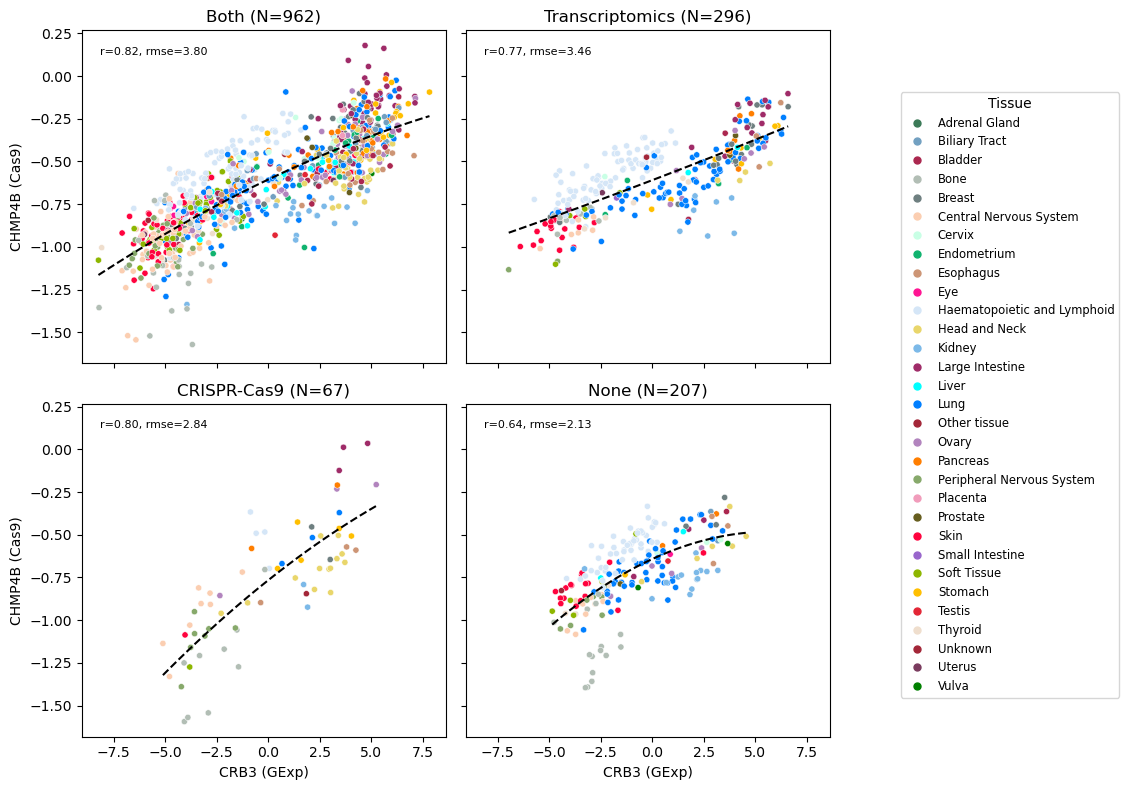

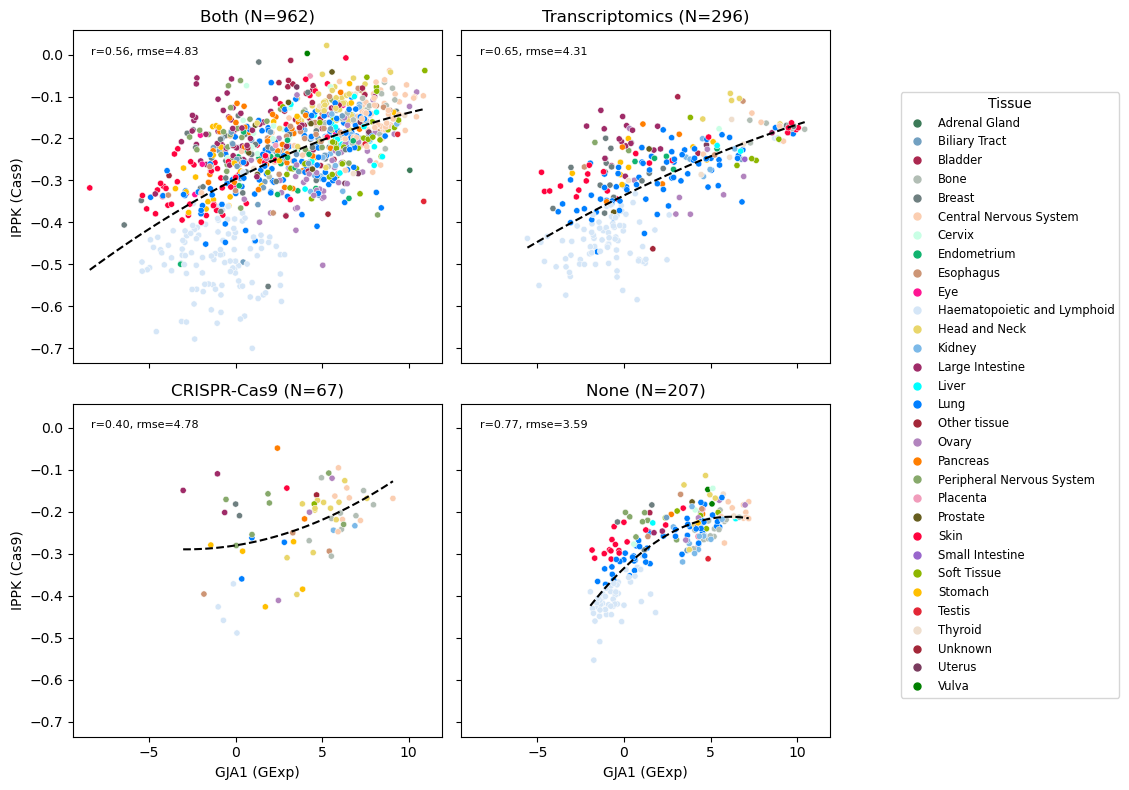

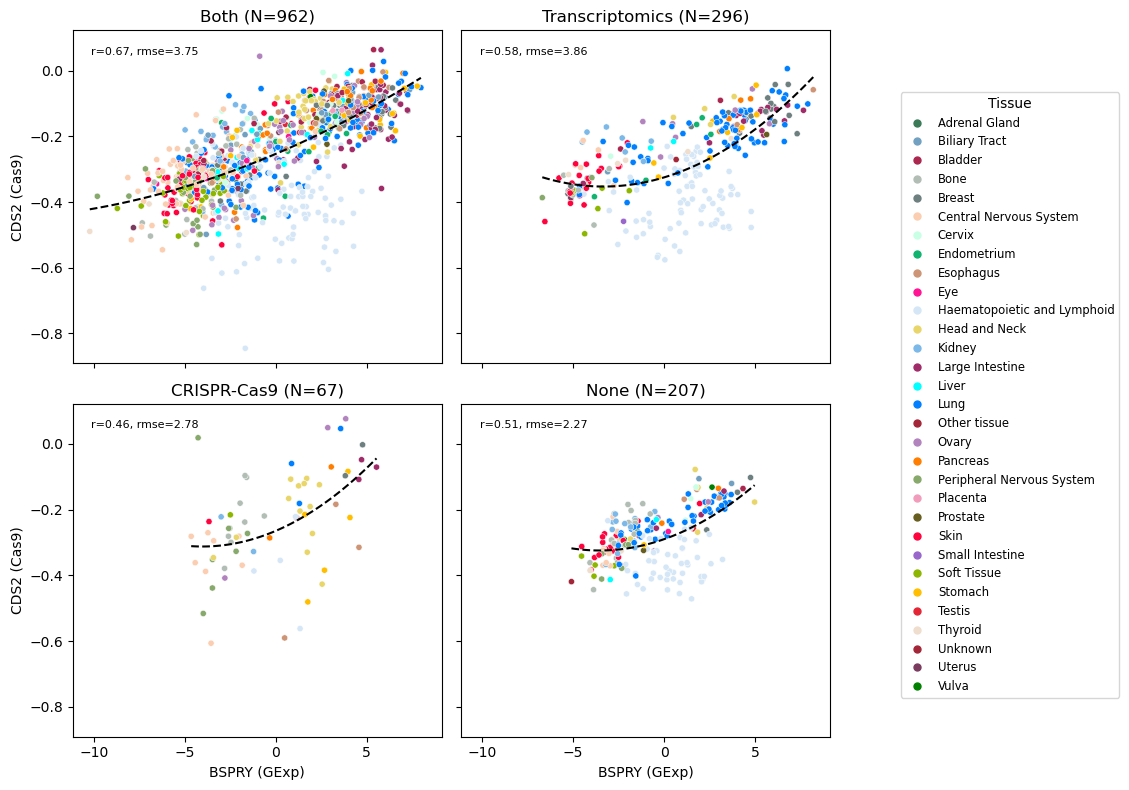

In [68]:
for row in df_res_vae_filtered_delta.head(3).itertuples():
    fig = plot_cas9_vs_gexp_comparison(
        cas9_id=row.y_id,
        gexp_id=row.x_id,
        cas9_df=cas9_df,
        gexp_df=gexp_df,
        measured_groups=measured_groups,
        tissue_map=tissue_map
    )
    plt.show()

<Axes: title={'center': 'EFR3A (Cas9) vs EFR3B (GEXP)'}, xlabel='EFR3B (GEXP)', ylabel='EFR3A (Cas9)'>

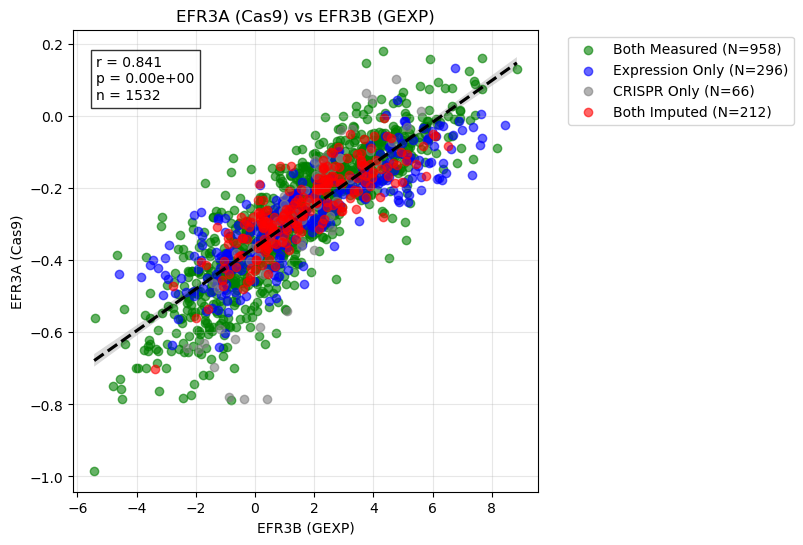

In [55]:
plot_scatter("EFR3A", "EFR3B", measured_groups=measured_groups, model_list_df=ss_cmp)

## cell line selection

In [101]:
df_res_vae_annot["log10fdr_orig"] = -np.log10(df_res_vae_annot["fdr_orig"])
df_res_vae_annot["log10fdr_vae"] = -np.log10(df_res_vae_annot["fdr_vae"])
df_res_vae_annot["diff_log10fdr"] = (
    df_res_vae_annot["log10fdr_vae"] - df_res_vae_annot["log10fdr_orig"]
)
df_res_vae_filtered = df_res_vae_annot[df_res_vae_annot["beta_vae"] > 0]
df_res_vae_filtered = df_res_vae_filtered.query("log10fdr_vae > 3 and log10fdr_orig < 3")

# df_res_vae_filtered = df_res_vae_filtered.query("skew_orig < -1.5 and skew_mosa < -1.5")
df_res_vae_filtered["beta_raw"] = df_res_vae_filtered.apply(calculate_beta_raw, axis=1)
df_res_vae_filtered = df_res_vae_filtered.query("beta_raw > 0")
df_res_vae_filtered = df_res_vae_filtered.reset_index(drop=True)

In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from joblib import Parallel, delayed
import time


def select_validation_cell_lines(
    df_res_vae_filtered,
    gexp_df,
    cas9_df,
    num_cell_lines=6,
    threshold_percentile=75,
    n_jobs=20,
    crispr_threshold=0,
    expression_threshold=0,
    create_visualizations=False,
    visualize_top_n=10,
    output_dir="./validation_results",
):
    """
    Integrated pipeline to select optimal cell lines for synthetic lethality validation.
    Enforces both CRISPR and expression thresholds to identify strong synthetic lethality.

    Parameters:
    - df_res_vae_filtered: DataFrame containing gene pairs and significance measurements
    - gexp_df: DataFrame containing gene expression data
    - cas9_df: DataFrame containing CRISPR scores
    - num_cell_lines: Number of cell lines to select
    - threshold_percentile: Percentile threshold for considering a cell line adequate
    - n_jobs: Number of parallel jobs for score calculation
    - crispr_threshold: Maximum CRISPR score to consider a dependency (default=-0.6)
    - expression_threshold: Maximum expression value to consider low expression (default=0)
    - create_visualizations: Whether to create visualizations
    - visualize_top_n: Number of top gene pairs to visualize
    - output_dir: Directory to save visualizations

    Returns:
    - Dictionary with selected cell lines and evaluation metrics
    """
    print("Starting optimized cell line selection pipeline...")
    overall_start_time = time.time()

    # Step 1: Extract gene pairs and weights from the filtered results dataframe
    print("Extracting gene pairs and weights...")
    gene_pairs = list(zip(df_res_vae_filtered["y_id"], df_res_vae_filtered["x_id"]))

    # Create weights based on diff_log10fdr (delta significance)
    weights = pd.Series(
        df_res_vae_filtered["diff_log10fdr"].values,
        index=pd.MultiIndex.from_tuples(gene_pairs, names=["cas9_gene", "gexp_gene"]),
    )

    # Normalize weights to range [0, 1]
    if not weights.empty and weights.max() != weights.min():
        weights = (weights - weights.min()) / (weights.max() - weights.min())

    # Step 2: Calculate validation scores using parallel processing with thresholds
    print(f"Calculating validation scores with both thresholds...")
    validation_scores = calculate_validation_scores(
        gene_pairs,
        gexp_df,
        cas9_df,
        df_res_vae_filtered,
        n_jobs=n_jobs,
        crispr_threshold=crispr_threshold,
        expression_threshold=expression_threshold,
    )

    # Check if any valid scores remain after filtering
    if validation_scores.sum().sum() == 0:
        print(f"ERROR: No gene pairs have cell lines that pass both thresholds")
        print(f"CRISPR > {crispr_threshold} AND Expression > {expression_threshold}")
        print("Please try less stringent thresholds.")
        return None

    # Step 3: Create binary coverage matrix
    print("Creating coverage matrix using threshold...")
    coverage_matrix = create_coverage_matrix(validation_scores, threshold_percentile)

    # Step 4: Select optimal cell lines with optimized algorithm
    print("Selecting optimal cell lines using optimized algorithm...")
    selection_results = select_optimal_cell_lines(
        coverage_matrix, weights, num_cell_lines
    )

    # Step 5: Evaluate the selection
    print("Evaluating cell line selection...")
    evaluation_results = evaluate_cell_line_selection(
        coverage_matrix,
        selection_results["selected_cell_lines"],
        weights,
        df_res_vae_filtered,
    )

    # Combine results
    results = {
        "selected_cell_lines": selection_results["selected_cell_lines"],
        "cell_line_coverage": selection_results["pairs_covered_per_cell"],
        "validation_scores": validation_scores,
        "coverage_matrix": coverage_matrix,
        "evaluation": evaluation_results,
        "gene_pair_examples": selection_results["gene_pair_examples"],
        "thresholds": {"crispr": crispr_threshold, "expression": expression_threshold},
    }

    overall_elapsed_time = time.time() - overall_start_time
    print(f"\nTotal pipeline execution time: {overall_elapsed_time:.2f} seconds")

    # Print a summary
    print("\n----- RESULTS SUMMARY -----")
    print(
        f"\nRESULTS WITH THRESHOLDS: CRISPR > {crispr_threshold} AND Expression > {expression_threshold}"
    )
    print("\nSelected Cell Lines:")
    for i, cell_line in enumerate(results["selected_cell_lines"]):
        num_pairs = len(selection_results["covered_by_cell_line"][i])
        print(
            f"{i+1}. {cell_line} - Covers {num_pairs} gene pairs "
            + f"({num_pairs/len(gene_pairs)*100:.2f}% of total)"
        )

    print(f"\nOverall Coverage: {evaluation_results['overall_coverage_percent']:.2f}%")
    print(f"Top Pair Coverage: {evaluation_results['top_pair_coverage_percent']:.2f}%")
    print(f"Weighted Coverage: {evaluation_results['weighted_coverage_percent']:.2f}%")

    # Create visualizations if requested
    if create_visualizations:
        # Implement visualization code here (from previous response)
        pass

    return results


def calculate_validation_scores(
    gene_pairs,
    gexp_df,
    cas9_df,
    df_res_vae_filtered,
    n_jobs=20,
    crispr_threshold=0,
    expression_threshold=0,
):
    """
    Calculate synthetic lethality validation scores for all gene pairs across all cell lines.
    Apply both CRISPR and expression thresholds for filtering.

    Parameters:
    - gene_pairs: List of tuples where each tuple is (cas9_gene, gexp_gene)
    - gexp_df: DataFrame containing gene expression data, with genes as columns
    - cas9_df: DataFrame containing CRISPR scores, with genes as columns
    - df_res_vae_filtered: DataFrame containing gene pairs and their diff_log10fdr values
    - n_jobs: Number of parallel jobs to run (default=20)
    - crispr_threshold: Maximum CRISPR score to consider a dependency (default=-0.6)
    - expression_threshold: Maximum expression value to consider low expression (default=0)

    Returns:
    - validation_score_matrix: DataFrame with gene pairs as rows and cell lines as columns
    """
    # Ensure we're working with cell lines common to both datasets
    common_cell_lines = gexp_df.index.intersection(cas9_df.index)
    print(
        f"Found {len(common_cell_lines)} cell lines common to both expression and CRISPR datasets"
    )

    # Initialize validation score matrix
    validation_scores = pd.DataFrame(
        index=pd.MultiIndex.from_tuples(gene_pairs, names=["cas9_gene", "gexp_gene"]),
        columns=common_cell_lines,
    )

    # Create a lookup dictionary for diff_log10fdr values
    diff_fdr_dict = {}
    for _, row in df_res_vae_filtered.iterrows():
        diff_fdr_dict[(row["y_id"], row["x_id"])] = row["diff_log10fdr"]

    # Normalize diff_log10fdr values to a range of [1, 2]
    if diff_fdr_dict:
        min_diff = min(diff_fdr_dict.values())
        max_diff = max(diff_fdr_dict.values())
        diff_range = max_diff - min_diff

        if diff_range > 0:
            for pair in diff_fdr_dict:
                # Scale to [0,1] and then to [1,2]
                diff_fdr_dict[pair] = 1 + (
                    (diff_fdr_dict[pair] - min_diff) / diff_range
                )

    # Function to process a single gene pair
    def process_gene_pair(pair_idx, cas9_gene, gexp_gene):
        # Check if genes exist in respective datasets
        if cas9_gene not in cas9_df.columns or gexp_gene not in gexp_df.columns:
            return pair_idx, None

        # Get CRISPR and expression values for all cell lines
        cas9_values = cas9_df[cas9_gene].reindex(common_cell_lines)
        gexp_values = gexp_df[gexp_gene].reindex(common_cell_lines)

        # Handle missing values
        valid_cells = cas9_values.notna() & gexp_values.notna()
        if valid_cells.sum() == 0:
            return pair_idx, None

        cas9_values = cas9_values[valid_cells]
        gexp_values = gexp_values[valid_cells]

        # Apply both threshold filters - only consider cell lines that pass both criteria
        # 1. CRISPR threshold: CRISPR score < crispr_threshold
        # 2. Expression threshold: Expression value < expression_threshold
        strong_dependency_mask = cas9_values > crispr_threshold
        high_expression_mask = gexp_values > expression_threshold

        # Combined mask: cell line must pass both filters
        combined_mask = strong_dependency_mask & high_expression_mask

        # If no cell lines pass both thresholds, return None
        if combined_mask.sum() == 0:
            return pair_idx, None

        # Filter values to only include cell lines that pass both thresholds
        cas9_filtered = cas9_values[combined_mask]
        gexp_filtered = gexp_values[combined_mask]

        # Calculate distance from the "ideal" top-right corner
        # First identify the most extreme values to define our reference point
        max_gexp = gexp_filtered.max()
        max_cas9 = cas9_filtered.max()

        # Calculate Euclidean distance to the reference top-right point
        # Normalize by the range of values to make dimensions comparable
        gexp_range = max_gexp - gexp_filtered.min()
        cas9_range = max_cas9 - cas9_filtered.min()

        if gexp_range == 0 or cas9_range == 0:
            return pair_idx, None

        # Calculate normalized distances
        # Smaller distance = closer to top-right = better synthetic lethality
        normalized_distances = np.sqrt(
            ((max_gexp - gexp_filtered) / gexp_range) ** 2
            + ((max_cas9 - cas9_filtered) / cas9_range) ** 2
        )

        # Convert distances to scores where higher is better (closer to top-right)
        sl_scores = 1 - (normalized_distances / np.sqrt(2))

        # Apply the diff_log10fdr weight to prioritize gene pairs with higher diff_log10fdr
        diff_fdr_weight = diff_fdr_dict.get((cas9_gene, gexp_gene), 1.0)
        weighted_scores = sl_scores * diff_fdr_weight

        # Create a result Series with all cell lines, setting scores to 0 for those that don't
        # meet both thresholds
        result_scores = pd.Series(0, index=cas9_values.index)
        result_scores[weighted_scores.index] = weighted_scores

        return pair_idx, (result_scores.index, result_scores.values)
    
    # Use joblib to parallelize the computation with reduced verbosity
    print(f"Processing {len(gene_pairs)} gene pairs with {n_jobs} parallel jobs...")
    print(
        f"Applying thresholds: CRISPR > {crispr_threshold} AND Expression > {expression_threshold}"
    )
    start_time = time.time()

    results = Parallel(n_jobs=n_jobs, verbose=0)(
        delayed(process_gene_pair)(i, cas9_gene, gexp_gene)
        for i, (cas9_gene, gexp_gene) in enumerate(gene_pairs)
    )

    # Process results and populate the validation scores dataframe
    filtered_pairs_count = 0
    for pair_idx, result in results:
        if result is not None:
            indices, values = result
            cas9_gene, gexp_gene = gene_pairs[pair_idx]
            validation_scores.loc[(cas9_gene, gexp_gene), indices] = values
            if values.sum() > 0:  # If at least one cell line passed both thresholds
                filtered_pairs_count += 1

    elapsed_time = time.time() - start_time
    print(f"Score calculation completed in {elapsed_time:.2f} seconds")
    print(
        f"{filtered_pairs_count} out of {len(gene_pairs)} gene pairs have at least one cell line"
    )
    print(
        f"that passes both thresholds (CRISPR < {crispr_threshold} AND Expression < {expression_threshold})"
    )

    # Fill any missing values with zeros
    return validation_scores.fillna(0)


def create_coverage_matrix(validation_scores, threshold_percentile=75):
    """
    Convert validation scores to a binary coverage matrix using a threshold.

    Parameters:
    - validation_scores: DataFrame with gene pairs as rows and cell lines as columns
    - threshold_percentile: Percentile value to use as threshold (default: 75th percentile)

    Returns:
    - Binary coverage matrix where 1 indicates the cell line adequately demonstrates
      the synthetic lethality for that gene pair
    """
    # Calculate threshold based on percentile of non-zero values
    non_zero_scores = validation_scores.values.flatten()
    non_zero_scores = non_zero_scores[non_zero_scores > 0]

    if len(non_zero_scores) == 0:
        threshold = 0
    else:
        threshold = np.percentile(non_zero_scores, threshold_percentile)

    print(
        f"Using threshold score of {threshold} (based on {threshold_percentile}th percentile)"
    )

    # Create binary coverage matrix
    coverage_matrix = (validation_scores >= threshold).astype(int)

    # Print coverage statistics
    total_pairs = coverage_matrix.shape[0]
    pairs_covered = (coverage_matrix.sum(axis=1) > 0).sum()
    print(
        f"Coverage matrix: {pairs_covered} of {total_pairs} pairs ({pairs_covered/total_pairs*100:.2f}%) "
        + f"are covered by at least one cell line"
    )

    return coverage_matrix


def select_optimal_cell_lines(coverage_matrix, weights, num_cell_lines=6):
    """
    Select the optimal set of cell lines using a weighted greedy algorithm.
    Optimized version with vectorized operations and progress reporting.

    Parameters:
    - coverage_matrix: Binary matrix where rows=gene pairs, columns=cell lines
    - weights: Series of importance weights for each gene pair
    - num_cell_lines: Number of cell lines to select

    Returns:
    - Dictionary with selected cell lines and coverage statistics
    """
    print("Starting optimized cell line selection...")
    start_time = time.time()

    # Make sure weights align with coverage_matrix index
    if weights is not None:
        weights = weights.reindex(coverage_matrix.index).fillna(0)
    else:
        weights = pd.Series(1.0, index=coverage_matrix.index)

    # Convert to numpy arrays for faster calculation
    coverage_array = coverage_matrix.values
    weights_array = weights.values
    cell_lines = coverage_matrix.columns.tolist()

    # Initialize variables
    selected_cell_lines = []
    selected_indices = []
    remaining_pairs = set(range(len(coverage_matrix)))

    # Track which pairs are covered by each selected cell line
    covered_by_cell_line = {}
    gene_pair_examples = {}

    # Pre-compute pair scores for each gene pair
    pair_validation_scores = {}
    for pair_idx in range(len(coverage_matrix)):
        cas9_gene, gexp_gene = coverage_matrix.index[pair_idx]
        # Store index lookup for faster access later
        pair_validation_scores[pair_idx] = {
            cell_idx: coverage_matrix.iloc[pair_idx, cell_idx]
            for cell_idx in range(len(cell_lines))
            if coverage_array[pair_idx, cell_idx] == 1
        }

    # Main selection loop with progress bar
    pbar = tqdm(total=min(num_cell_lines, len(cell_lines)), desc="Selecting cell lines")

    for i in range(num_cell_lines):
        if not remaining_pairs:
            pbar.update(num_cell_lines - i)
            pbar.close()
            print(f"All gene pairs are covered. Only needed {i} cell lines.")
            break

        # Calculate weighted coverage for each cell line
        weighted_coverage = {}
        cell_line_pairs = {}

        # This is the bottleneck - optimize by using vectorized operations
        for cell_idx, cell_line in enumerate(cell_lines):
            if cell_idx in selected_indices:
                continue

            # Vectorized operation: multiply coverage by weights and sum
            cell_coverage = coverage_array[:, cell_idx]
            covered_indices = np.where(cell_coverage == 1)[0]
            covered_indices = [idx for idx in covered_indices if idx in remaining_pairs]

            if not covered_indices:
                weighted_coverage[cell_idx] = 0
                cell_line_pairs[cell_idx] = (set(), [])
                continue

            weighted_sum = sum(weights_array[idx] for idx in covered_indices)

            weighted_coverage[cell_idx] = weighted_sum

            # Store pairs covered by this cell line with their scores
            newly_covered_pairs = set(covered_indices)

            # Get pair details for examples, but limit to avoid excessive processing
            pair_scores = []
            for pair_idx in list(newly_covered_pairs)[
                :50
            ]:  # Limit to 50 for efficiency
                cas9_gene, gexp_gene = coverage_matrix.index[pair_idx]
                # Use pre-computed validation scores
                validation_score = pair_validation_scores[pair_idx].get(cell_idx, 0)
                pair_weight = weights_array[pair_idx]
                pair_scores.append(
                    (cas9_gene, gexp_gene, validation_score * pair_weight)
                )

            cell_line_pairs[cell_idx] = (newly_covered_pairs, pair_scores)

        # Select the cell line with highest coverage
        if not weighted_coverage or all(
            score == 0 for score in weighted_coverage.values()
        ):
            pbar.update(num_cell_lines - i)
            pbar.close()
            print(
                f"No more cell lines can cover remaining pairs. Stopping at {i} cell lines."
            )
            break

        best_cell_idx = max(weighted_coverage.items(), key=lambda x: x[1])[0]
        best_cell_line = cell_lines[best_cell_idx]

        selected_cell_lines.append(best_cell_line)
        selected_indices.append(best_cell_idx)

        # Store the covered pairs and example gene pairs
        newly_covered, pair_scores = cell_line_pairs[best_cell_idx]
        covered_by_cell_line[i] = newly_covered

        # Sort pair_scores by the validation score (higher is better)
        pair_scores.sort(key=lambda x: x[2], reverse=True)
        gene_pair_examples[i] = pair_scores

        # Update the remaining pairs
        remaining_pairs -= newly_covered

        # Log progress
        pbar.update(1)
        pbar.set_postfix({"covered": len(newly_covered)})

    pbar.close()

    # Calculate pairs covered per cell line
    pairs_covered_per_cell = {
        cell_line: len(covered_by_cell_line[i])
        for i, cell_line in enumerate(selected_cell_lines)
        if i in covered_by_cell_line
    }

    # Calculate coverage statistics
    total_pairs = len(coverage_matrix)
    all_covered_pairs = set()
    for covered_set in covered_by_cell_line.values():
        all_covered_pairs.update(covered_set)

    elapsed_time = time.time() - start_time
    print(f"Cell line selection completed in {elapsed_time:.2f} seconds")
    print(
        f"Selected {len(selected_cell_lines)} cell lines that collectively cover "
        + f"{len(all_covered_pairs)} of {total_pairs} gene pairs ({len(all_covered_pairs)/total_pairs*100:.2f}%)"
    )

    coverage_stats = {
        "selected_cell_lines": selected_cell_lines,
        "total_coverage_percent": len(all_covered_pairs) / total_pairs * 100,
        "covered_by_cell_line": covered_by_cell_line,
        "pairs_covered_per_cell": pairs_covered_per_cell,
        "gene_pair_examples": gene_pair_examples,
    }

    return coverage_stats


def evaluate_cell_line_selection(
    coverage_matrix, selected_cell_lines, weights, df_res_vae_filtered, top_n=100
):
    """
    Evaluate the quality of the selected cell lines.

    Parameters:
    - coverage_matrix: Binary coverage matrix
    - selected_cell_lines: List of selected cell line names/indices
    - weights: Series of importance weights for each gene pair
    - df_res_vae_filtered: Original dataframe with gene pairs and significance metrics
    - top_n: Number of top gene pairs to consider for high-priority coverage

    Returns:
    - Dictionary with evaluation metrics
    """
    # Make sure weights align with coverage_matrix index
    if weights is not None:
        weights = weights.reindex(coverage_matrix.index).fillna(0)
    else:
        weights = pd.Series(1.0, index=coverage_matrix.index)

    # Get indices of top gene pairs by weight (most significant deltaFDR)
    top_pairs_idx = weights.nlargest(min(top_n, len(weights))).index

    # Calculate overall coverage
    covered_pairs = set()
    for cell_line in selected_cell_lines:
        cell_idx = coverage_matrix.columns.get_loc(cell_line)
        for pair_idx in range(len(coverage_matrix)):
            if coverage_matrix.iloc[pair_idx, cell_idx] == 1:
                covered_pairs.add(pair_idx)

    # Calculate coverage of top pairs
    top_pair_indices = [coverage_matrix.index.get_loc(pair) for pair in top_pairs_idx]
    top_pairs_covered = sum(1 for idx in top_pair_indices if idx in covered_pairs)

    # Find which top pairs are not covered
    uncovered_top_pairs = [
        coverage_matrix.index[idx]
        for idx in top_pair_indices
        if idx not in covered_pairs
    ]

    # Calculate weighted coverage
    weighted_coverage = sum(weights.iloc[pair_idx] for pair_idx in covered_pairs)

    # Calculate maximum possible weighted coverage
    max_weighted_coverage = weights.sum()

    # Store significant deltaFDR values for covered and uncovered top pairs
    significant_pairs_covered = []
    for pair in top_pairs_idx:
        if coverage_matrix.index.get_loc(pair) in covered_pairs:
            cas9_gene, gexp_gene = pair
            row = df_res_vae_filtered[
                (df_res_vae_filtered["y_id"] == cas9_gene)
                & (df_res_vae_filtered["x_id"] == gexp_gene)
            ]
            if not row.empty:
                significant_pairs_covered.append(
                    (
                        cas9_gene,
                        gexp_gene,
                        row["diff_log10fdr"].values[0],
                        row["log10fdr_vae"].values[0],
                    )
                )

    # Sort by significance
    significant_pairs_covered.sort(key=lambda x: x[2], reverse=True)

    return {
        "overall_coverage_percent": len(covered_pairs) / len(coverage_matrix) * 100,
        "top_pair_coverage_percent": top_pairs_covered / len(top_pairs_idx) * 100,
        "weighted_coverage_percent": weighted_coverage / max_weighted_coverage * 100,
        "total_pairs_covered": len(covered_pairs),
        "total_pairs": len(coverage_matrix),
        "top_pairs_covered": top_pairs_covered,
        "top_pairs_total": len(top_pairs_idx),
        "uncovered_top_pairs": uncovered_top_pairs,
        "significant_pairs_covered": significant_pairs_covered,
    }


def visualize_results(results, df_res_vae_filtered, gexp_df, cas9_df, output_dir="."):
    """
    Create visualizations of the cell line selection results.

    Parameters:
    - results: Dictionary returned by select_validation_cell_lines
    - df_res_vae_filtered: DataFrame with gene pairs and significance metrics
    - gexp_df: Gene expression DataFrame
    - cas9_df: CRISPR scores DataFrame
    - output_dir: Directory to save visualizations
    """

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # 1. Selected cell lines coverage heatmap
    plt.figure(figsize=(12, 8))
    selected_scores = results["validation_scores"][results["selected_cell_lines"]]

    # If there are many gene pairs, sample a subset for clearer visualization
    if len(selected_scores) > 50:
        # Sample top pairs by weight and some random pairs
        weights = pd.Series(
            df_res_vae_filtered["diff_log10fdr"].values,
            index=pd.MultiIndex.from_tuples(
                zip(df_res_vae_filtered["y_id"], df_res_vae_filtered["x_id"]),
                names=["cas9_gene", "gexp_gene"],
            ),
        )
        top_pairs = weights.nlargest(30).index
        random_pairs = selected_scores.sample(20).index
        plot_pairs = list(set(top_pairs).union(set(random_pairs)))
        selected_scores = selected_scores.loc[plot_pairs]

    # Create the heatmap
    ax = sns.heatmap(selected_scores, cmap="viridis", linewidths=0.5)
    plt.title("Validation Scores for Selected Cell Lines", fontsize=14)
    plt.ylabel("Gene Pairs", fontsize=12)
    plt.xlabel("Cell Lines", fontsize=12)

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.savefig(f"{output_dir}/selected_cell_lines_heatmap.png", dpi=300)

    # 2. Bar chart of gene pairs covered by each cell line
    plt.figure(figsize=(10, 6))
    cell_coverage = pd.Series(results["cell_line_coverage"])
    cell_coverage.plot(kind="bar", color="skyblue")
    plt.title("Number of Gene Pairs Covered by Each Selected Cell Line", fontsize=14)
    plt.ylabel("Number of Gene Pairs", fontsize=12)
    plt.xlabel("Cell Line", fontsize=12)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.savefig(
        f"{output_dir}/cell_line_coverage_bar.png", dpi=300, bbox_inches="tight"
    )

    # 3. Example gene pair scatter plots for each cell line
    for cell_idx, cell_line in enumerate(
        results["selected_cell_lines"][:3]
    ):  # Plot first 3 cell lines
        if cell_idx not in results["gene_pair_examples"]:
            continue

        examples = results["gene_pair_examples"][cell_idx]
        if not examples:
            continue

        # Plot top 4 gene pairs for this cell line
        fig, axes = plt.subplots(2, 2, figsize=(14, 12))
        axes = axes.flatten()

        for i, (cas9_gene, gexp_gene, score) in enumerate(examples[:4]):
            if i >= len(axes):
                break

            # Get CRISPR and expression values
            cas9_values = cas9_df[cas9_gene]
            gexp_values = gexp_df[gexp_gene]

            # Handle missing values
            valid_cells = cas9_values.notna() & gexp_values.notna()
            cas9_values = cas9_values[valid_cells]
            gexp_values = gexp_values[valid_cells]

            # Create scatter plot
            ax = axes[i]

            # Highlight the selected cell line
            if cell_line in cas9_values.index and cell_line in gexp_values.index:
                highlighted_x = gexp_values[cell_line]
                highlighted_y = cas9_values[cell_line]

                # Plot all points
                ax.scatter(gexp_values, cas9_values, alpha=0.5, c="lightgray")

                # Highlight selected cell line
                ax.scatter(
                    [highlighted_x],
                    [highlighted_y],
                    c="red",
                    s=100,
                    edgecolor="black",
                    zorder=10,
                )
            else:
                ax.scatter(gexp_values, cas9_values, alpha=0.5)

            # Find the gene pair in the original dataframe
            row = df_res_vae_filtered[
                (df_res_vae_filtered["y_id"] == cas9_gene)
                & (df_res_vae_filtered["x_id"] == gexp_gene)
            ]

            # Add correlation and p-value if available
            corr = np.corrcoef(gexp_values, cas9_values)[0, 1]

            if not row.empty:
                diff_fdr = row["diff_log10fdr"].values[0]
                log_fdr = row["log10fdr_vae"].values[0]
                title = (
                    f"{cas9_gene} (CRISPR) vs {gexp_gene} (Expr)\n"
                    + f"r = {corr:.3f}, deltaFDR = {diff_fdr:.3f}, -log10(FDR) = {log_fdr:.3f}"
                )
            else:
                title = f"{cas9_gene} (CRISPR) vs {gexp_gene} (Expr)\nr = {corr:.3f}"

            ax.set_title(title)
            ax.set_xlabel(f"{gexp_gene} Expression")
            ax.set_ylabel(f"{cas9_gene} CRISPR Score")

            # Add a trend line
            m, b = np.polyfit(gexp_values, cas9_values, 1)
            x_range = np.linspace(min(gexp_values), max(gexp_values), 100)
            ax.plot(x_range, m * x_range + b, "k--", alpha=0.7)

        plt.suptitle(f"Top Gene Pairs for Cell Line: {cell_line}", fontsize=16)
        plt.subplots_adjust(top=0.93)
        plt.savefig(f"{output_dir}/cell_line_{cell_line}_examples.png", dpi=300, bbox_inches="tight")

    # 4. Coverage summary pie chart
    plt.figure(figsize=(8, 8))
    coverage_data = [
        results["evaluation"]["total_pairs_covered"],
        results["evaluation"]["total_pairs"]
        - results["evaluation"]["total_pairs_covered"],
    ]
    plt.pie(
        coverage_data,
        labels=["Covered", "Not Covered"],
        autopct="%1.1f%%",
        colors=["#66b3ff", "#ff9999"],
        startangle=90,
        shadow=True,
    )
    plt.axis("equal")
    plt.title("Overall Gene Pair Coverage", fontsize=14)
    plt.savefig(f"{output_dir}/coverage_pie_chart.png", dpi=300, bbox_inches="tight")

    # print(f"Visualizations saved to {output_dir}")

In [118]:
def visualize_pair_examples(
    cas9_gene,
    gexp_gene,
    cas9_df,
    gexp_df,
    selected_cell_lines,
    df_res_vae_filtered,
    output_dir=".",
    crispr_threshold=-0.1,
    expression_threshold=5,
):
    """
    Create an enhanced visualization of a gene pair showing both CRISPR and expression thresholds.

    Parameters:
    - cas9_gene: Gene name for CRISPR data
    - gexp_gene: Gene name for expression data
    - cas9_df: DataFrame containing CRISPR scores
    - gexp_df: DataFrame containing gene expression data
    - selected_cell_lines: List of selected cell lines to highlight
    - df_res_vae_filtered: DataFrame with gene pairs and significance metrics
    - output_dir: Directory to save visualizations
    - crispr_threshold: Maximum CRISPR score to consider a dependency
    - expression_threshold: Maximum expression value to consider low expression
    """
    # Get CRISPR and expression values
    cas9_values = cas9_df[cas9_gene]
    gexp_values = gexp_df[gexp_gene]

    # Handle missing values
    valid_cells = cas9_values.notna() & gexp_values.notna()
    cas9_values = cas9_values[valid_cells]
    gexp_values = gexp_values[valid_cells]

    # Create figure
    plt.figure(figsize=(10, 8))

    # Find the reference point (bottom-left corner)
    max_gexp = gexp_values.max()
    max_cas9 = cas9_values.max()

    # Create masks for each threshold
    crispr_mask = cas9_values > crispr_threshold
    expr_mask = gexp_values > expression_threshold

    # Combined mask for cells that pass both thresholds
    both_mask = crispr_mask & expr_mask

    # Categorize cell lines into four groups
    neither_mask = ~crispr_mask & ~expr_mask
    crispr_only_mask = crispr_mask & ~expr_mask
    expr_only_mask = ~crispr_mask & expr_mask

    # Plot each group with different colors
    plt.scatter(
        gexp_values[neither_mask],
        cas9_values[neither_mask],
        alpha=0.3,
        c="gray",
        label="Neither threshold met",
    )

    plt.scatter(
        gexp_values[crispr_only_mask],
        cas9_values[crispr_only_mask],
        alpha=0.5,
        c="orange",
        label=f"Only CRISPR > {crispr_threshold}",
    )

    plt.scatter(
        gexp_values[expr_only_mask],
        cas9_values[expr_only_mask],
        alpha=0.5,
        c="blue",
        label=f"Only Expression > {expression_threshold}",
    )

    plt.scatter(
        gexp_values[both_mask],
        cas9_values[both_mask],
        alpha=0.8,
        c="green",
        label="Both thresholds met",
    )

    # Plot top-right reference point for cells that pass both thresholds
    if both_mask.sum() > 0:
        max_gexp_both = gexp_values[both_mask].max()
        max_cas9_both = cas9_values[both_mask].max()
        plt.scatter(
            [max_gexp_both],
            [max_cas9_both],
            c="purple",
            s=150,
            marker="*",
            edgecolor="black",
            zorder=10,
            label="top-right reference",
        )

    # Highlight selected cell lines
    for cell_line in selected_cell_lines:
        if cell_line in cas9_values.index and cell_line in gexp_values.index:
            plt.scatter(
                [gexp_values[cell_line]],
                [cas9_values[cell_line]],
                c="red",
                s=100,
                edgecolor="black",
                zorder=10,
            )

    if any(
        cell_line in cas9_values.index and cell_line in gexp_values.index
        for cell_line in selected_cell_lines
    ):
        plt.scatter(
            [], [], c="red", s=100, edgecolor="black", label="Selected cell lines"
        )

    # Add horizontal and vertical lines at the thresholds
    plt.axhline(
        y=crispr_threshold,
        color="red",
        linestyle="--",
        alpha=0.7,
        label=f"CRISPR threshold ({crispr_threshold})",
    )
    plt.axvline(
        x=expression_threshold,
        color="blue",
        linestyle="--",
        alpha=0.7,
        label=f"Expression threshold ({expression_threshold})",
    )

    # Add correlation and significance info
    corr = np.corrcoef(gexp_values, cas9_values)[0, 1]

    # Add info about how many cell lines pass the thresholds
    both_count = both_mask.sum()
    total_cells = len(cas9_values)

    # Get diff_log10fdr if available
    row = df_res_vae_filtered[
        (df_res_vae_filtered["y_id"] == cas9_gene)
        & (df_res_vae_filtered["x_id"] == gexp_gene)
    ]

    if not row.empty:
        diff_fdr = row["diff_log10fdr"].values[0]
        log_fdr = row["log10fdr_vae"].values[0]
        title = (
            f"{cas9_gene} (CRISPR) vs {gexp_gene} (Expr)\n"
            + f"r = {corr:.3f}, deltaFDR = {diff_fdr:.3f}, -log10(FDR) = {log_fdr:.3f}\n"
            + f"{both_count}/{total_cells} cell lines pass both thresholds"
        )
    else:
        title = (
            f"{cas9_gene} (CRISPR) vs {gexp_gene} (Expr)\n"
            + f"r = {corr:.3f}\n"
            + f"{both_count}/{total_cells} cell lines pass both thresholds"
        )

    plt.title(title)
    plt.xlabel(f"{gexp_gene} Expression")
    plt.ylabel(f"{cas9_gene} CRISPR Score")

    # Add a trend line for all data
    m, b = np.polyfit(gexp_values, cas9_values, 1)
    x_range = np.linspace(min(gexp_values), max(gexp_values), 100)
    plt.plot(x_range, m * x_range + b, "k--", alpha=0.5, label="All data trend")

    # Add a trend line for cells that pass both thresholds if there are enough points
    if both_mask.sum() >= 3:
        m_both, b_both = np.polyfit(gexp_values[both_mask], cas9_values[both_mask], 1)
        plt.plot(
            x_range,
            m_both * x_range + b_both,
            "g-",
            alpha=0.7,
            label="Both thresholds trend",
        )

    plt.legend(loc="best", fontsize="small")
    plt.grid(alpha=0.2)
    plt.tight_layout()

    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    plt.savefig(f"{output_dir}/{cas9_gene}_vs_{gexp_gene}.png", dpi=300)
    plt.close()

In [111]:
results = select_validation_cell_lines(
    df_res_vae_filtered=df_res_vae_filtered,
    gexp_df=gexp_df,
    cas9_df=cas9_df,
    num_cell_lines=6,
    threshold_percentile=90,
    crispr_threshold=-0.1,
    expression_threshold=5,
    n_jobs=40,  # Adjust based on your system's CPU count
)

Starting optimized cell line selection pipeline...
Extracting gene pairs and weights...
Calculating validation scores with both thresholds...
Found 1532 cell lines common to both expression and CRISPR datasets
Processing 391 gene pairs with 40 parallel jobs...
Applying thresholds: CRISPR > -0.1 AND Expression > 5


/tmp/ipykernel_1635886/1500395728.py:259: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.35174669 0.15483956 0.89334426 0.25231935 0.27844549 0.65105574
 0.07333265 0.64860888 0.75887285 0.19735    0.4339842  0.35360681
 0.1105333  0.38129349 0.10047926 0.79616165 0.16495338 0.63400605
 1.1007931  0.44702765 0.85637833 0.49261623]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
/tmp/ipykernel_1635886/1500395728.py:259: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.37970237 0.45655519 0.93318704 0.87091568 0.56477898 0.30182764
 0.70406637 0.29744282 0.45617825 0.39000959 0.53960532 0.55127267
 1.04699333 0.56428994 0.43442682 0.73904026 0.50940956 0.42500525
 0.77362394 0.56193996 0.61946641 0.38880092 0.49758218 0.34526307
 0.60666637 0.59316128 0.60516266 0.20542917 0.85378354

Score calculation completed in 2.76 seconds
253 out of 391 gene pairs have at least one cell line
that passes both thresholds (CRISPR < -0.1 AND Expression < 5)
Creating coverage matrix using threshold...
Using threshold score of 0.6878776120700317 (based on 90th percentile)


/tmp/ipykernel_1635886/1500395728.py:295: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return validation_scores.fillna(0)


Coverage matrix: 235 of 391 pairs (60.10%) are covered by at least one cell line
Selecting optimal cell lines using optimized algorithm...
Starting optimized cell line selection...


Selecting cell lines: 100%|██████████| 6/6 [00:00<00:00, 45.02it/s, covered=8] 


Cell line selection completed in 0.33 seconds
Selected 6 cell lines that collectively cover 104 of 391 gene pairs (26.60%)
Evaluating cell line selection...

Total pipeline execution time: 3.44 seconds

----- RESULTS SUMMARY -----

RESULTS WITH THRESHOLDS: CRISPR < -0.1 AND Expression < 5

Selected Cell Lines:
1. SIDM01394 - Covers 38 gene pairs (9.72% of total)
2. SIDM00687 - Covers 26 gene pairs (6.65% of total)
3. SIDM01795 - Covers 11 gene pairs (2.81% of total)
4. SIDM00749 - Covers 11 gene pairs (2.81% of total)
5. SIDM00638 - Covers 10 gene pairs (2.56% of total)
6. SIDM00890 - Covers 8 gene pairs (2.05% of total)

Overall Coverage: 26.60%
Top Pair Coverage: 49.00%
Weighted Coverage: 33.28%


In [119]:
df_res_vae_filtered.head(10)

y_id     x_id  n_orig  beta_orig    lr_orig  covs_orig  pval_orig  \
0    TP53     BBC3   965.0   0.110732  12.134729      237.0   0.000495   
1    BCL6     DLG5   965.0   0.215613  16.220783      237.0   0.000056   
2  SH3GL1  RAB3IL1   965.0   0.111133   8.804462      237.0   0.003005   
3  SH3GL1    WDFY3   965.0   0.172156  16.597452      237.0   0.000046   
4   ITSN2    LRP11   965.0   0.154827  13.488944      237.0   0.000240   
5   MYBL2      VXN   965.0   0.171521  23.721675      237.0   0.000001   
6  CHMP4B     CRB3   965.0   0.231514  13.579396      237.0   0.000229   
7    PAX5   NCKAP1   965.0   0.213132  18.631612      237.0   0.000016   
8    FPGS     GJC1   965.0   0.137994  11.277706      237.0   0.000784   
9  SH3GL1    FNIP2   965.0   0.102219  11.008478      237.0   0.000907   

   fdr_orig   n_vae  beta_vae     lr_vae  covs_vae      pval_vae  \
0  0.151029  1532.0  0.135177  32.169949     242.0  1.412588e-08   
1  0.058661  1532.0  0.238631  36.386353     242.0  1.618324e-09   
2  0.200993  1532.0  0.143048  27.402769     242.0  1.651945e-07   
3  0.018066  1532.0  0.182727  35.484617     242.0  2.570728e-09   
4  0.113909  1532.0  0.168004  32.207447     242.0  1.385586e-08   
5  0.006341  1532.0  0.178107  42.450453     242.0  7.249561e-11   
6  0.134757  1532.0  0.250799  31.374327     242.0  2.127759e-08   
7  0.025188  1532.0  0.227225  36.129213     242.0  1.846578e-09   
8  0.140449  1532.0  0.157540  28.389332     242.0  9.921050e-08   
9  0.131348  1532.0  0.109731  27.898444     242.0  1.278525e-07   

        fdr_vae  log10p_orig  log10p_vae  diff_log10p  skew_orig  skew_mosa  \
0  3.970784e-05     3.305470    7.849985     4.544515   2.282172   1.306683   
1  4.549110e-06     4.248935    8.790934     4.542000  -2.290573  -3.362503   
2  4.643618e-04     2.522163    6.782004     4.259841  -3.212028  -2.876568   
3  7.226316e-06     4.335235    8.589944     4.254709  -3.212028  -2.876568   
4  3.894883e-05     3.619837    7.858366     4.238529  -3.013881  -2.866391   
5  2.037852e-07     5.953420   10.139688     4.186268  -0.477860  -0.173248   
6  5.981129e-05     3.640768    7.672078     4.031309  -0.280349  -0.175174   
7  5.190731e-06     4.799781    8.733632     3.933851  -3.820113  -3.190277   
8  6.972018e-05     3.105443    7.003442     3.897999  -1.061990  -0.924905   
9  1.796967e-04     3.042411    6.893291     3.850879  -3.212028  -2.876568   

                target_detailed target  log10fdr_orig  log10fdr_vae  \
0                             1      1       0.820941      4.401124   
1                             4      4       1.231650      5.342074   
2                             4      4       0.696819      3.333144   
3                             4      4       1.743140      5.141083   
4  No link; Gene not in network      -       0.943442      4.409506   
5  No link; Gene not in network      -       2.197825      6.690827   
6                            5+     5+       0.870450      4.223217   
7                             4      4       1.598803      5.284772   
8                            5+     5+       0.852480      4.156642   
9                            5+     5+       0.881577      3.745460   

   diff_log10fdr  beta_raw  
0       3.580183  0.088224  
1       4.110423  0.038761  
2       2.636324  0.035370  
3       3.397943  0.050403  
4       3.466063  0.031373  
5       4.493003  0.036787  
6       3.352767  0.056993  
7       3.685969  0.028320  
8       3.304162  0.037858  
9       2.863883  0.052007

In [120]:
for i, row in df_res_vae_filtered.head(5).iterrows():
    visualize_pair_examples(
        cas9_gene=row["y_id"],
        gexp_gene=row["x_id"],
        cas9_df=cas9_df,
        gexp_df=gexp_df,
        selected_cell_lines=results["selected_cell_lines"],
        df_res_vae_filtered=df_res_vae_filtered,
        output_dir="./validation_results_remove_all_latent",
    )

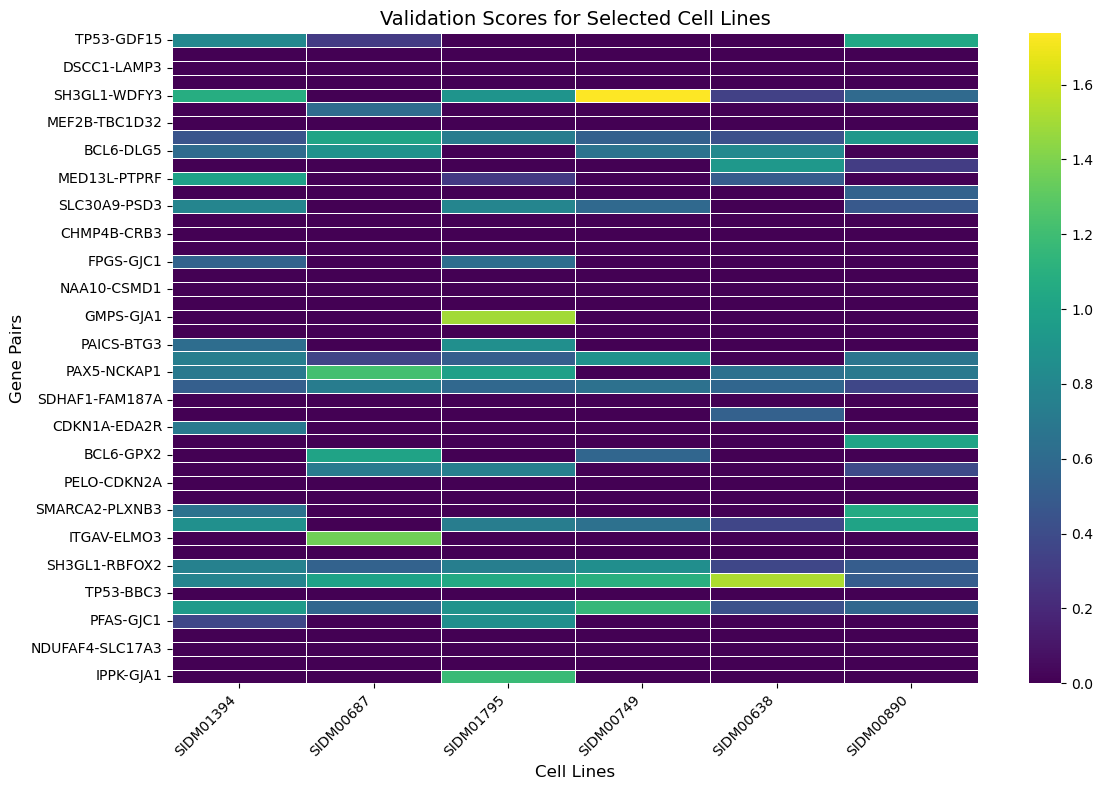

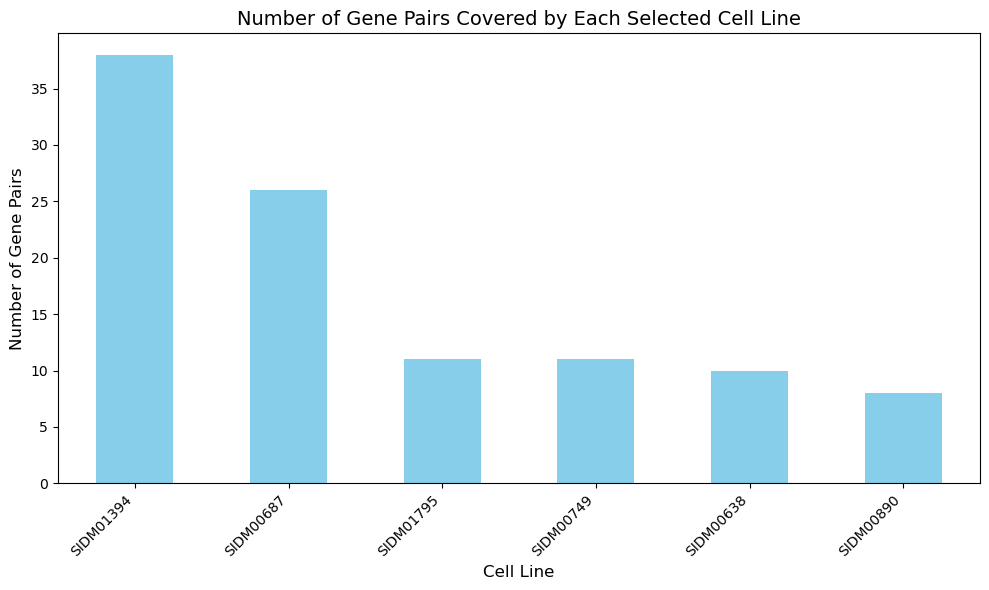

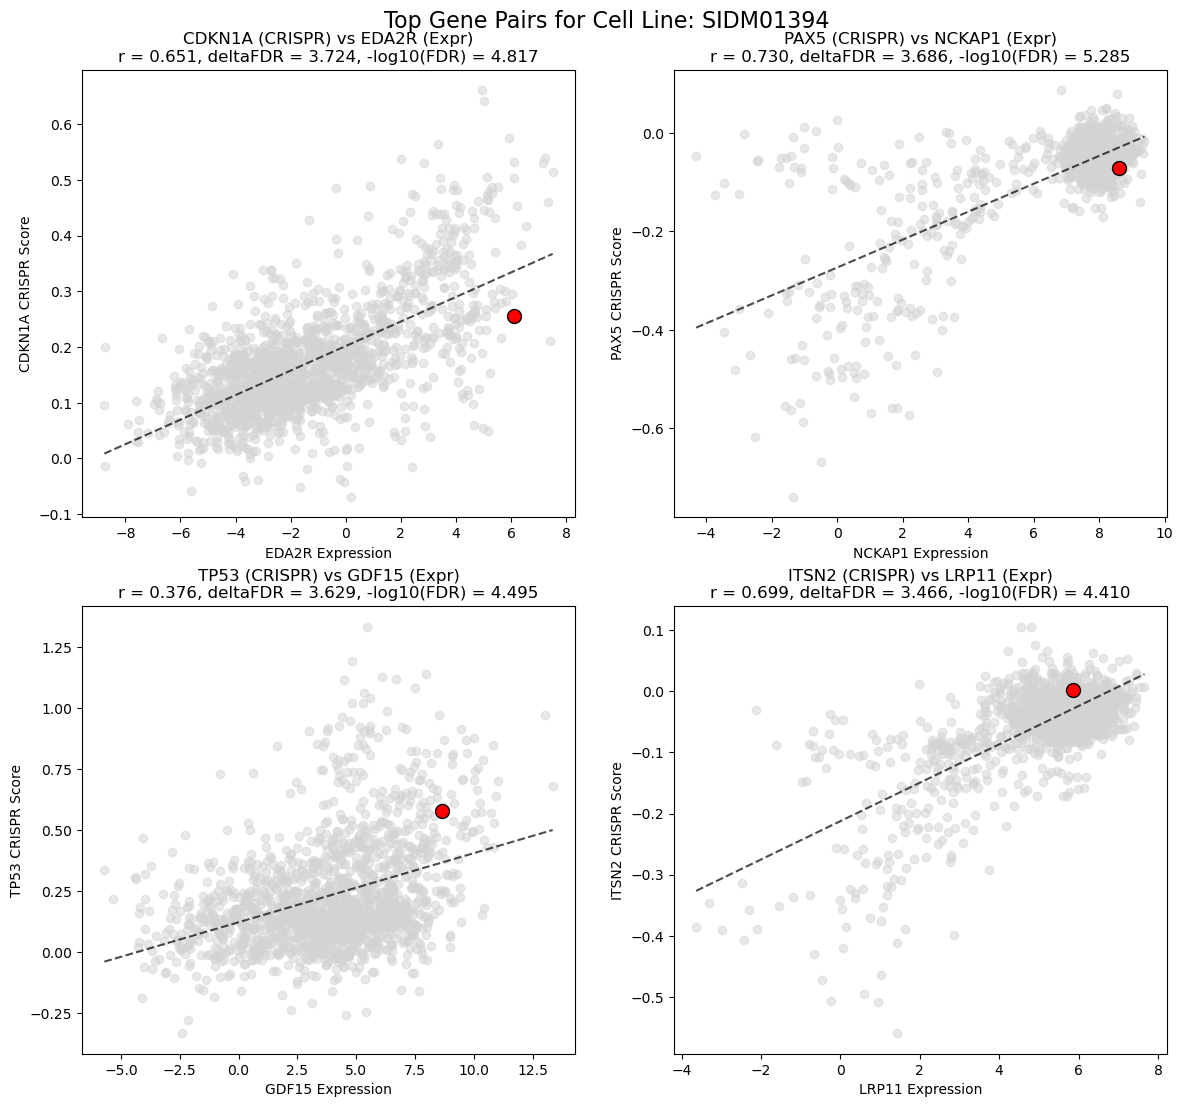

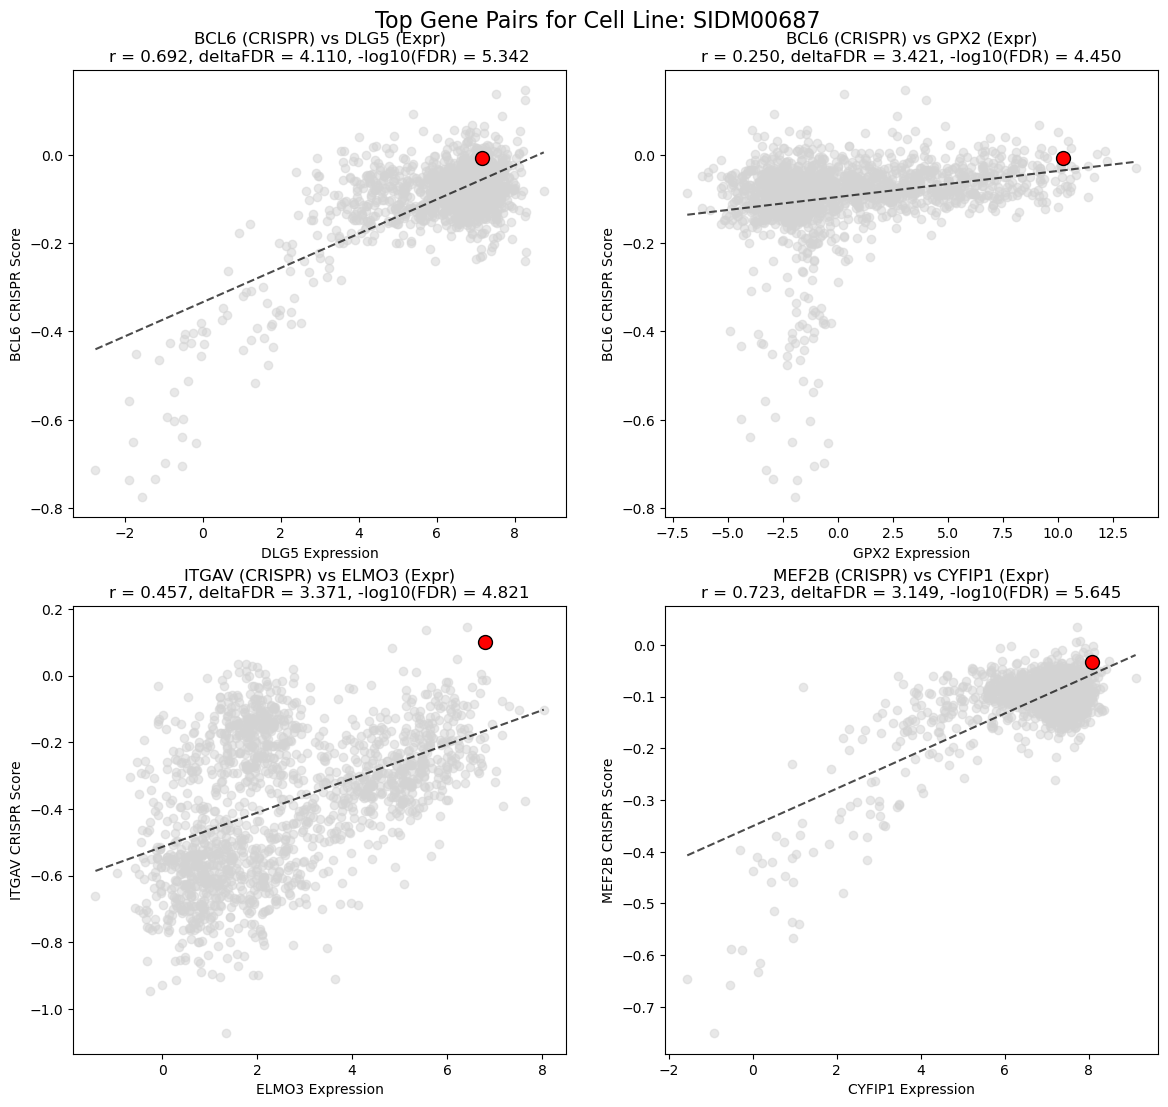

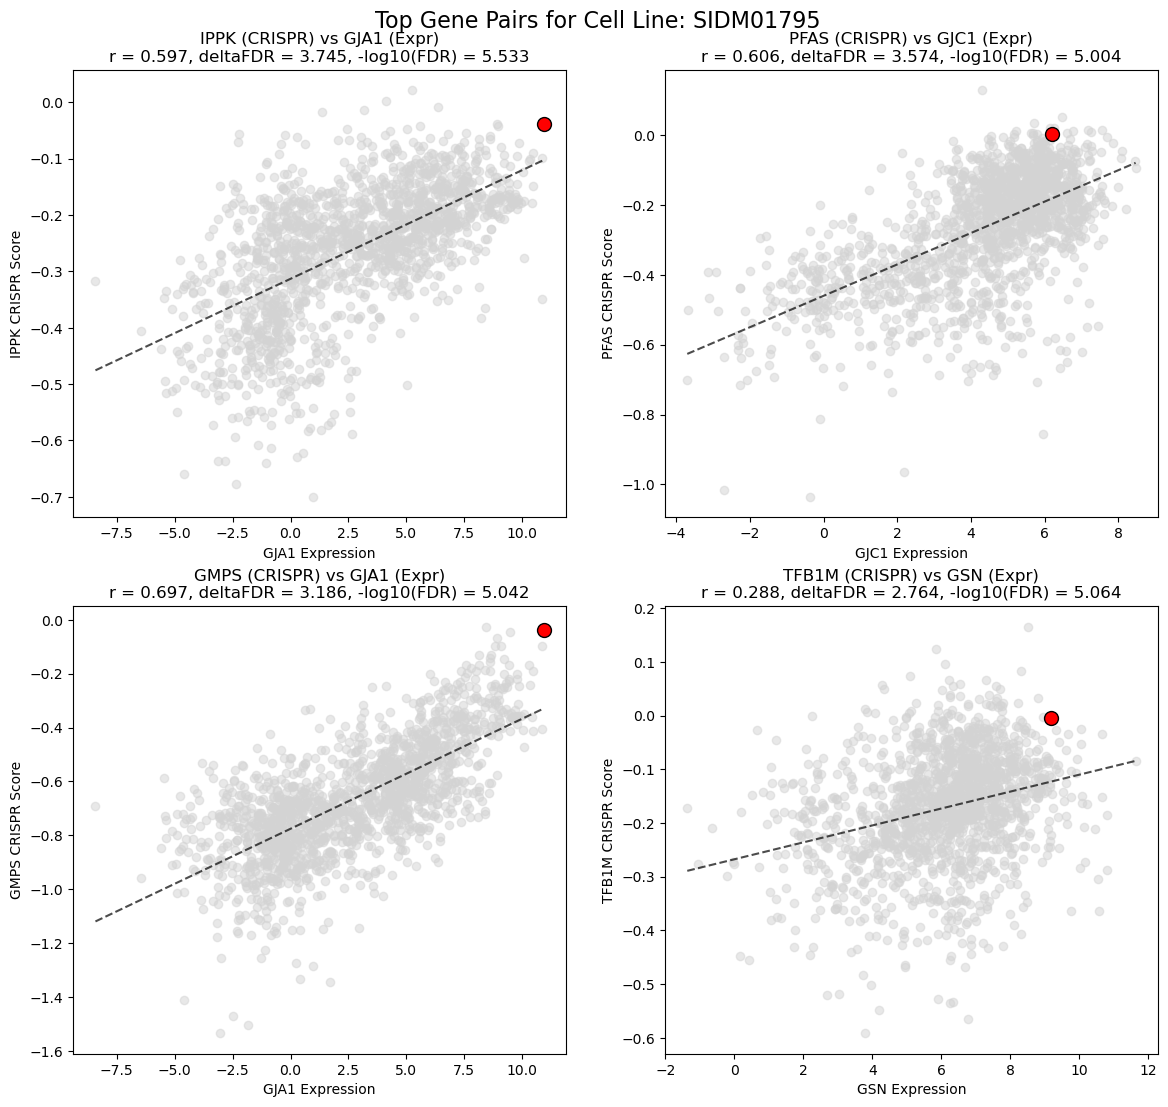

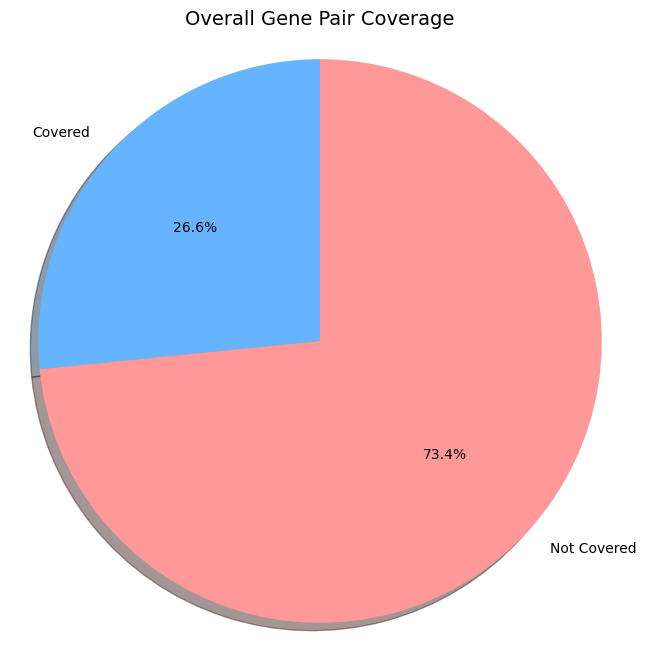

In [121]:
visualize_results(
    results=results,
    df_res_vae_filtered=df_res_vae_filtered,
    gexp_df=gexp_df,
    cas9_df=cas9_df,
    output_dir="./validation_results_remove_all_latent",
)

In [123]:
results["coverage_matrix"]

SIDM00001  SIDM00003  SIDM00005  SIDM00006  SIDM00007  \
cas9_gene gexp_gene                                                          
TP53      BBC3               0          0          0          0          0   
BCL6      DLG5               0          0          0          0          0   
SH3GL1    RAB3IL1            0          0          0          0          0   
          WDFY3              0          0          0          0          1   
ITSN2     LRP11              0          0          0          1          1   
...                        ...        ...        ...        ...        ...   
CNOT7     SERPINB9           0          0          0          0          0   
VMA21     F8                 0          0          0          0          0   
CTNNB1    MPP6               0          0          0          0          0   
SOX2      GAS6               0          0          0          0          0   
GTF2F1    ANPEP              0          0          0          0          0   

                     SIDM00008  SIDM00011  SIDM00015  SIDM00016  SIDM00017  \
cas9_gene gexp_gene                                                          
TP53      BBC3               0          0          0          0          0   
BCL6      DLG5               0          0          0          1          1   
SH3GL1    RAB3IL1            0          0          0          0          0   
          WDFY3              0          0          0          0          0   
ITSN2     LRP11              0          0          1          0          0   
...                        ...        ...        ...        ...        ...   
CNOT7     SERPINB9           0          0          0          0          0   
VMA21     F8                 0          0          0          0          0   
CTNNB1    MPP6               0          0          0          0          0   
SOX2      GAS6               0          0          0          0          0   
GTF2F1    ANPEP              0          0          0          0          0   

                     SIDM00018  SIDM00023  SIDM00026  SIDM00027  SIDM00028  \
cas9_gene gexp_gene                                                          
TP53      BBC3               0          0          0          0          0   
BCL6      DLG5               0          0          0          1          0   
SH3GL1    RAB3IL1            0          0          0          0          0   
          WDFY3              0          0          0          0          0   
ITSN2     LRP11              0          1          0          0          0   
...                        ...        ...        ...        ...        ...   
CNOT7     SERPINB9           0          0          0          0          0   
VMA21     F8                 0          0          0          0          0   
CTNNB1    MPP6               0          0          0          0          0   
SOX2      GAS6               0          0          0          0          0   
GTF2F1    ANPEP              0          0          0          0          0   

                     ...  SIDM01970  SIDM01971  SIDM01972  SIDM01973  \
cas9_gene gexp_gene  ...                                               
TP53      BBC3       ...          0          0          0          0   
BCL6      DLG5       ...          0          0          0          0   
SH3GL1    RAB3IL1    ...          0          0          0          0   
          WDFY3      ...          0          0          0          0   
ITSN2     LRP11      ...          1          0          1          1   
...                  ...        ...        ...        ...        ...   
CNOT7     SERPINB9   ...          0          0          0          0   
VMA21     F8         ...          0          0          0          0   
CTNNB1    MPP6       ...          0          0          0          0   
SOX2      GAS6       ...          0          0          0          0   
GTF2F1    ANPEP      ...          0          0          0          0   

                     SIDM01974  SIDM019

In [23]:
# You can access the selected cell lines
selected_cell_lines = results["selected_cell_lines"]
print("Selected cell lines:", selected_cell_lines)

# Get the gene pairs that each cell line is best for demonstrating
for i, cell_line in enumerate(selected_cell_lines):
    examples = results["gene_pair_examples"][i]
    print(f"\nTop gene pairs for {cell_line}:")
    for cas9_gene, gexp_gene, score in examples[:10]:  # Show top 10
        print(f"  {cas9_gene} (CRISPR) - {gexp_gene} (Expr) - Score: {score:.4f}")

Selected cell lines: ['SIDM01079', 'SIDM00689', 'SIDM00428', 'SIDM00272', 'SIDM00677', 'SIDM01265']

Top gene pairs for SIDM01079:
  SOX10 (CRISPR) - DDC (Expr) - Score: 1.0000
  SOX10 (CRISPR) - HNF4A (Expr) - Score: 0.9661
  SOX10 (CRISPR) - CLDN2 (Expr) - Score: 0.9521
  BRAF (CRISPR) - CLDN2 (Expr) - Score: 0.9327
  SOX10 (CRISPR) - LGALS4 (Expr) - Score: 0.9175
  BRAF (CRISPR) - DDC (Expr) - Score: 0.8848
  SOX10 (CRISPR) - TM4SF4 (Expr) - Score: 0.8655
  SOX10 (CRISPR) - LRRC31 (Expr) - Score: 0.8626
  BRAF (CRISPR) - SSTR1 (Expr) - Score: 0.8568
  IRF4 (CRISPR) - GPA33 (Expr) - Score: 0.7878

Top gene pairs for SIDM00689:
  POU2AF1 (CRISPR) - PARVG (Expr) - Score: 0.8960
  POU2AF1 (CRISPR) - CD3D (Expr) - Score: 0.8808
  MYB (CRISPR) - CCL22 (Expr) - Score: 0.8642
  SH3GL1 (CRISPR) - CTSW (Expr) - Score: 0.8005
  MYB (CRISPR) - CPNE5 (Expr) - Score: 0.7816
  SH3GL1 (CRISPR) - NKG7 (Expr) - Score: 0.7399
  POU2AF1 (CRISPR) - HERC5 (Expr) - Score: 0.7275
  EBF1 (CRISPR) - SPN (Exp